# SMM4H Task 5

### Covid19 Tweet Classification

La tarea 5 se enfoca en la clasificación de tweets donde el autor diga explicitamente que él mismo o alguien conocido está enfermo de Covid19, o que haya un riesgo alto de estar contagiado debido a que presenta síntomas.

El dataset de entrenamiento está compuesto por un total de 6465 tweets etiquetados.
* 5439 Tweets negativos.
    * 0 para los casos negativos.
* 1026 Tweets positivos.
    * 1 para los casos positivos o potenciales de Covid19.
    
Un dataset de validación con un total de 715 Tweets etiquetados.
* 594 Tweets negativos.
* 122 Tweets positivos.

El dataset de prueba será liberado el 28 de febrero.

In [ ]:
# pip install --upgrade tensorflow

In [ ]:
# pip install --upgrade keras

In [7]:
from transformers import (
   AutoConfig,
    AutoModel,
   AutoTokenizer,
   AutoModelForSequenceClassification,
   AdamW,
   Trainer,
   TrainingArguments,
    TFBertModel
)
import transformers

from tensorflow import keras
# from tensorflow.keras import layers
from keras.preprocessing.sequence import pad_sequences
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from gensim.models import Word2Vec, FastText, KeyedVectors
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from collections import defaultdict
import operator
import json
import pandas as pd
import numpy as np
import os
import csv
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from pathlib import Path
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, precision_score, recall_score, \
    confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
import time
import matplotlib.pyplot as plt            # library for visualization
import re
import string
import nltk
import gc
from wordcloud import STOPWORDS
import seaborn as sns
from random import shuffle
from tqdm.auto import tqdm

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="3"

if torch.cuda.is_available():    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(4))
# If not...
else:
    print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

Using TensorFlow backend.
/002/usuarios/p345336/.local/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


There are 8 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
torch.cuda.device(5)

In [10]:
torch.cuda.set_device(5)

In [11]:
torch.cuda.is_available()

True

In [12]:
torch.cuda.current_device()

5

In [13]:
torch.cuda.get_device_name()

'Tesla V100-SXM2-32GB'

In [8]:
# import time
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

In [ ]:
# from pynvml import *
# nvmlInit()
# h = nvmlDeviceGetHandleByIndex(3)
# info = nvmlDeviceGetMemoryInfo(h)
# print(f'total    : {info.total}')
# print(f'free     : {info.free}')
# print(f'used     : {info.used}')

In [14]:
import gc
torch.cuda.empty_cache()
gc.collect()

125

# Loading Data

In [15]:
'''
Lee el archivo de texto tsv, hace una lista de oraciones y una lista con la etiqueta de cada oración.
'''

def read_data(file_path, test=False):
    file_path = Path(file_path)

    raw_text = file_path.read_text().strip()
    raw_docs = re.split(r'\n\t?\n', raw_text)

    for doc in raw_docs:
        tweet_ids = []
        user_ids = []
        tweets = []
        labels = []
        for line in doc.split('\n'):
            if test:
                tweet_id, user_id, tweet = line.split('\t')
            else:
                tweet_id, user_id, tweet, label = line.split('\t')
            if tweet_id == 'tweet_id':
                continue
            if test:
                tweet_ids.append(int(tweet_id))
                user_ids.append(int(user_id))
                tweets.append(tweet)
            else:
                tweet_ids.append(int(tweet_id))
                user_ids.append(int(user_id))
                tweets.append(tweet)
                labels.append(int(label))
    if test:
        return tweet_ids, user_ids, tweets
    else:
        return tweet_ids, user_ids, tweets, labels

In [16]:
tweet_ids, user_ids, tweets_train, train_labels = read_data('train_5.tsv')

tweet_ids_test, user_ids_test, tweets_test = read_data('test_5.tsv', test=True)

tweet_ids_val, user_ids_val, tweets_val, val_labels = read_data('valid_5.tsv')

In [17]:
unique_tags = set(tag for tag in train_labels)
tag2id = {'Negative' if tag==0 else 'Positive':id for id, tag in enumerate(unique_tags)}
id2tag = {id: tag for tag, id in tag2id.items()}

print(unique_tags)
print(tag2id)
print(id2tag)

{0, 1}
{'Negative': 0, 'Positive': 1}
{0: 'Negative', 1: 'Positive'}


In [18]:
# Especify the number of labels in the dataset
num_labels = len(unique_tags)
print(num_labels)

2


In [19]:
df_train = pd.DataFrame()
df_train['text'] = tweets_train
df_train['target'] = train_labels
df_val = pd.DataFrame()
df_val['text'] = tweets_val
df_val['target'] = val_labels

# Data Visualization & Analysis

## Tweet Examples

In [14]:
print('\033[93m' + id2tag[train_labels[2]] + ' Tweet: ' + tweets_train[2])
print('')
print('\033[94m' + id2tag[train_labels[4]] + ' Tweet: ' + tweets_train[4])

Positive Tweet: For those who believe they are immortal and continue to go out to the park without paying attention to the order to remain at home, these are the x-rays of a 28-year-old boy intubated in the ICU in my hospital for #coronavirus. Hint: the lungs are black, white is pneumonia

Negative Tweet: I went to the movies and the air was on. Now I'm out to eat and Olive Garden has the air on. I see these establishments are doing their best to fight the coronavirus.


## Training set class size comparison

In [62]:
'''
Realiza una grafica de pastel de la proporcion de las clases
'''

def pie_plot(data_labels, tag2id):
    count = []
    labels = list(tag2id.keys())
    for tag in labels:
        count.append(data_labels.count(tag2id[tag]))
        
    # Declare a figure with a custom size
    fig = plt.figure(figsize=(5, 5))

    def func(pct, allvals):
        absolute = int(round(pct/100.*np.sum(allvals), 2))
        return "{:.1f}%\n({:d} tweets)".format(pct, absolute)

    # Declare pie chart, where the slices will be ordered and plotted counter-clockwise:
    plt.pie(count, labels=labels, autopct=lambda pct: func(pct, count),
            shadow=True, startangle=90, textprops=dict(color="w"))

    # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.axis('equal')  
    # Display the chart
    plt.show()
    print(f'Total size = {len(data_labels)}')
    return

### Training Set Size

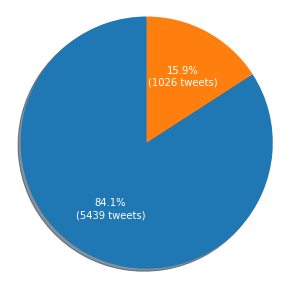

Total size = 6465


In [63]:
pie_plot(train_labels, tag2id)

## Validation Set Size

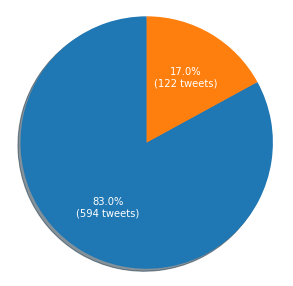

Total size = 716


In [64]:
pie_plot(val_labels, tag2id)

## Metafeatures distribution on Training & Validation set

In [65]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_val['word_count'] = df_val['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_val['unique_word_count'] = df_val['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_val['stop_word_count'] = df_val['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# # url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_val['url_count'] = df_val['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_val['mean_word_length'] = df_val['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_val['char_count'] = df_val['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_val['punctuation_count'] = df_val['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_val['hashtag_count'] = df_val['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_val['mention_count'] = df_val['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [66]:
def plot_count_sums(df, lengths, tag2id, name):
    count_sums = []
    labels = list(tag2id.keys())
    for tag in labels:
        count_sums.append(sum(df[df['target'] == tag2id[tag]][name]))
    
    ax = sns.barplot(labels, count_sums)
    ax.set_ylabel(name)
    plt.show()
    
    count_tweet_proportion = [i / j for i, j in zip(count_sums, lengths)] 
    print('Proporcion de # de apariciones entre # de tweets por clase')
    print(f'Proporcion clase {labels[0]}: {count_tweet_proportion[0]}'
          f' Proporcion clase {labels[1]}: {count_tweet_proportion[1]}')
    return count_sums

In [67]:
Positive_tweets = df_train['target'] == 1
Negative_tweets = df_train['target'] == 0
lengths = [Negative_tweets.values.sum(), Positive_tweets.values.sum()]
labels = list(tag2id.keys())
labels

['Negative', 'Positive']

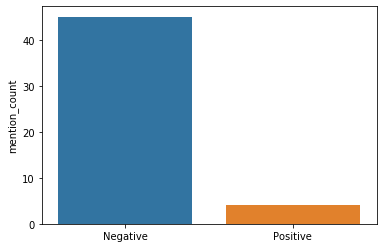

Proporcion de # de apariciones entre # de tweets por clase
Proporcion clase Negative: 0.00827357970215113 Proporcion clase Positive: 0.003898635477582846


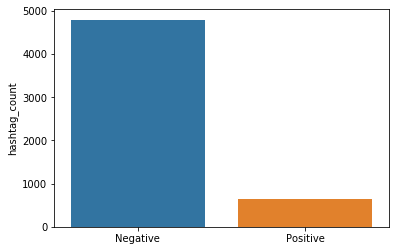

Proporcion de # de apariciones entre # de tweets por clase
Proporcion clase Negative: 0.882147453576025 Proporcion clase Positive: 0.6169590643274854


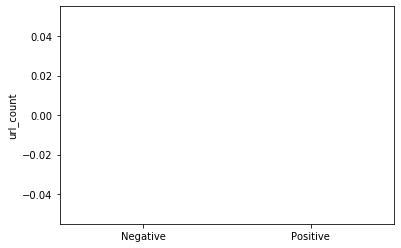

Proporcion de # de apariciones entre # de tweets por clase
Proporcion clase Negative: 0.0 Proporcion clase Positive: 0.0


In [68]:
lengths = [Negative_tweets.values.sum(), Positive_tweets.values.sum()]

count_sums = plot_count_sums(df_train, lengths, tag2id, 'mention_count')
count_tweet_proportion = [i / j for i, j in zip(count_sums, lengths)] 

count_sums = plot_count_sums(df_train, lengths, tag2id, 'hashtag_count')
count_tweet_proportion = [i / j for i, j in zip(count_sums, lengths)] 

count_sums = plot_count_sums(df_train, lengths, tag2id, 'url_count')
count_tweet_proportion = [i / j for i, j in zip(count_sums, lengths)] 

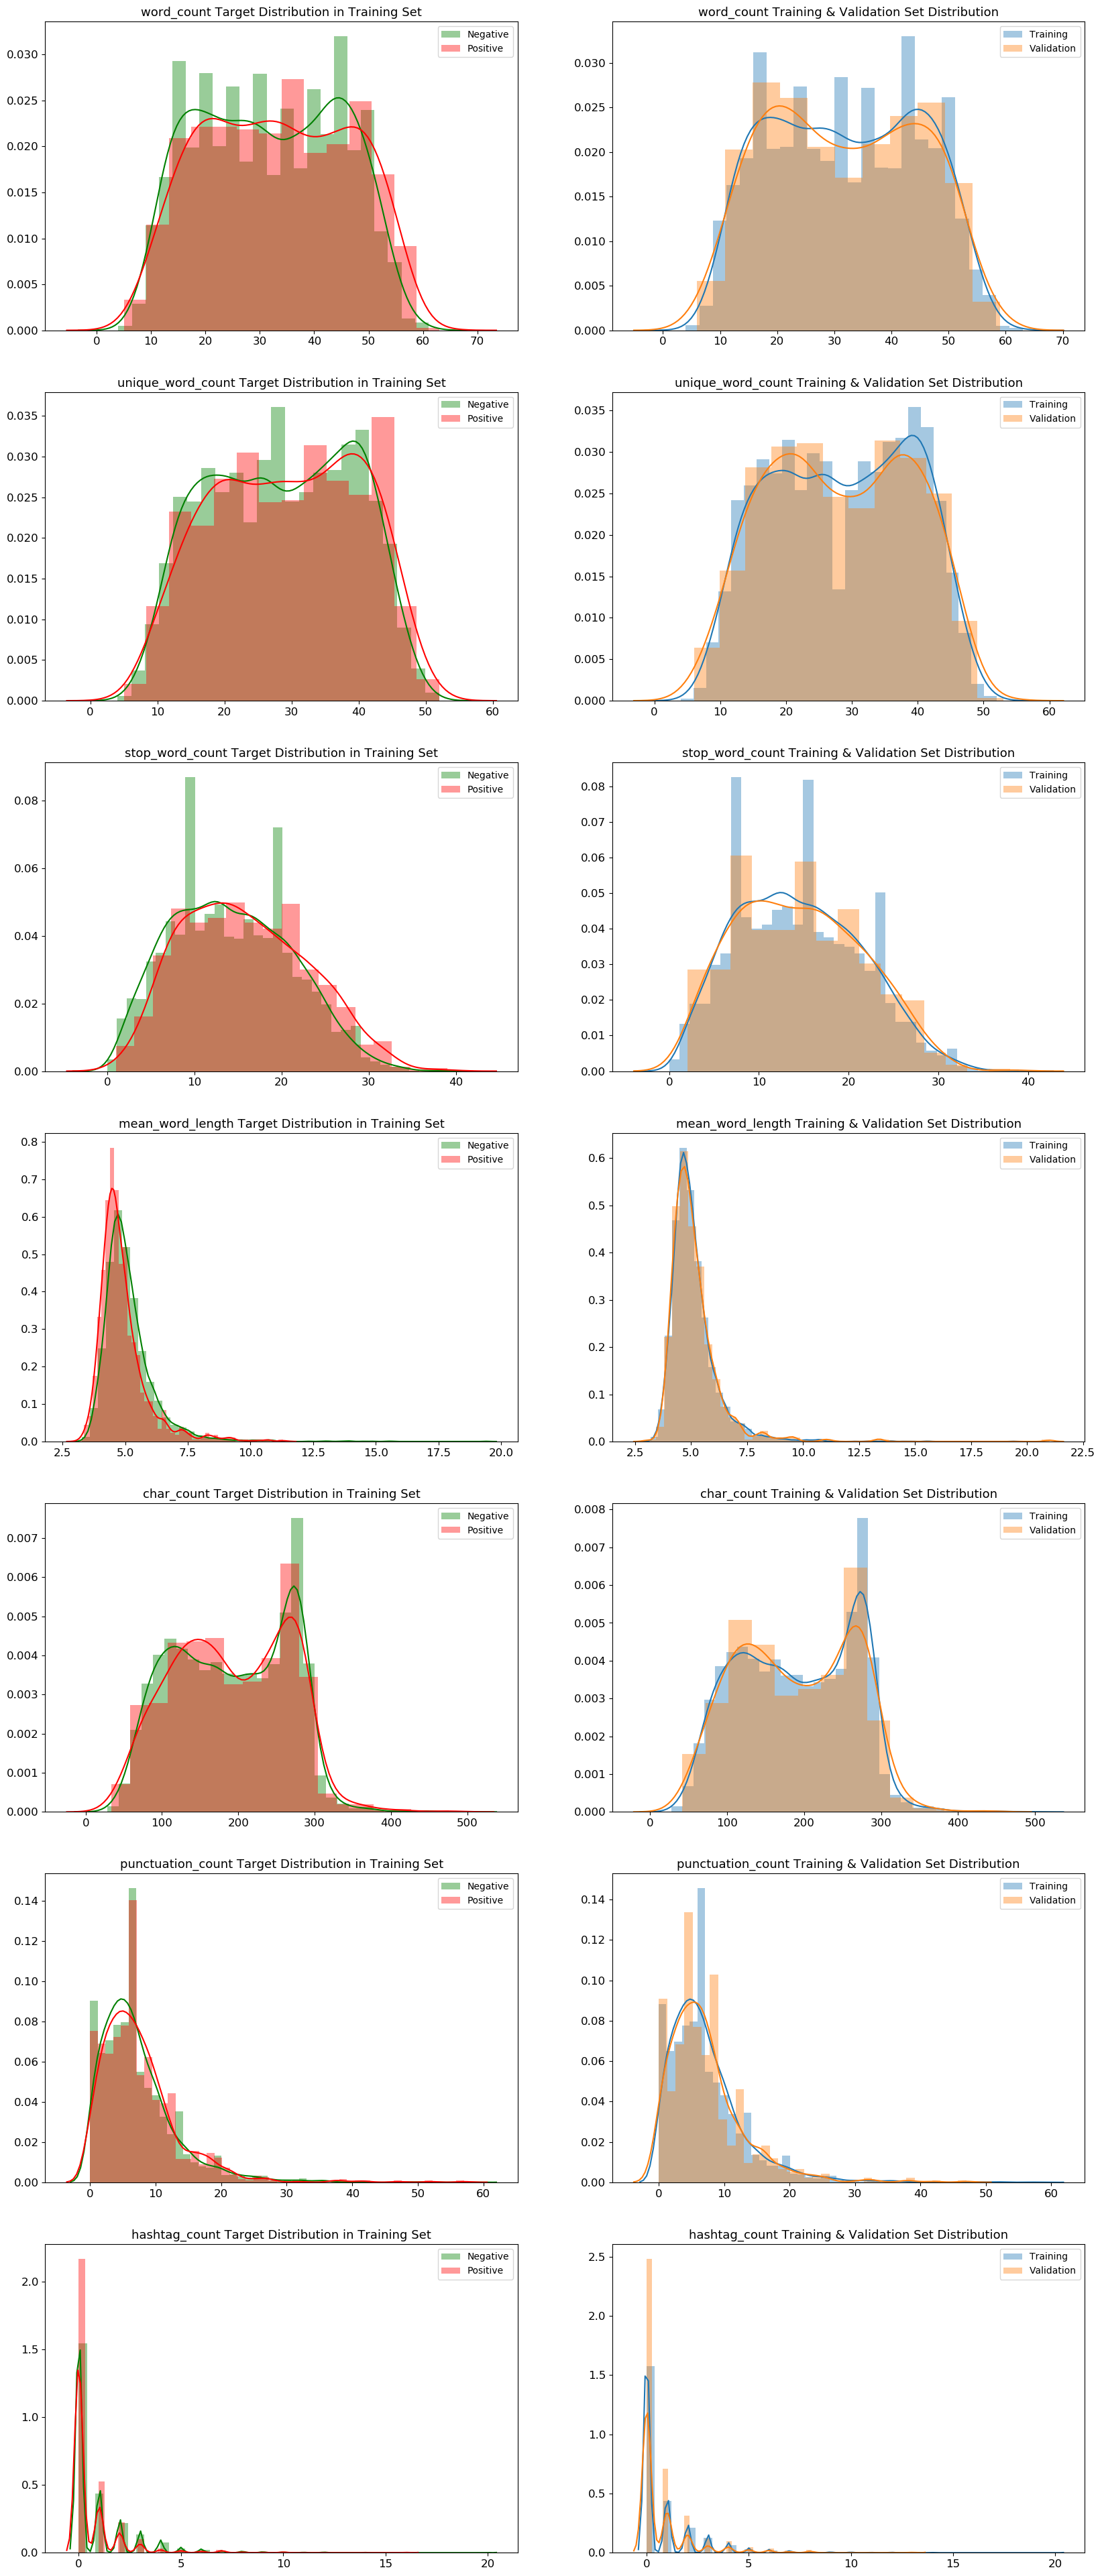

In [69]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count']

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[Negative_tweets][feature], label='Negative', ax=axes[i][0], color='green')
#     sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Negative', ax=axes[i][0], color='green', kde_kws={'bw':1})
    sns.distplot(df_train.loc[Positive_tweets][feature], label='Positive', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_val[feature], label='Validation', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Validation Set Distribution', fontsize=13)

plt.show()

## N-grams Analysis

Visualización de los unigramas, bigramas y trigramas más frecuentes del set de entrenamiento para cada clase.

In [ ]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [ ]:
def get_ngram_count(dftext, indices, n_gram=1):
    ngram_count_dict = defaultdict(int)
    for tweet in dftext[indices]['text']:
        for word in generate_ngrams(tweet, n_gram):
            ngram_count_dict[word] += 1
    df_ngram_count = pd.DataFrame(sorted(ngram_count_dict.items(), key=lambda x: x[1])[::-1])
    return df_ngram_count

In [ ]:
def plot_ngrams(dfpos, dfneg, N, ngrams='unigrams'):
    fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
    plt.tight_layout()

    sns.barplot(y=dfneg[0].values[:N], x=dfneg[1].values[:N], ax=axes[0], color='red')
    sns.barplot(y=dfpos[0].values[:N], x=dfpos[1].values[:N], ax=axes[1], color='green')

    for i in range(2):
        axes[i].spines['right'].set_visible(False)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', labelsize=13)
        axes[i].tick_params(axis='y', labelsize=13)

    axes[0].set_title(f'Top {N} most common {ngrams} in Negative Tweets', fontsize=15)
    axes[1].set_title(f'Top {N} most common {ngrams} in Positive Tweets', fontsize=15)

    plt.show()
    return

In [ ]:
### Number of most common n-grams to visualize
N = 100

In [ ]:
df_positive_unigrams = get_ngram_count(df_train, Positive_tweets, n_gram=1)
df_negative_unigrams = get_ngram_count(df_train, Negative_tweets, n_gram=1)

plot_ngrams(df_positive_unigrams, df_negative_unigrams, N, ngrams='unigrams')

In [ ]:
df_positive_bigrams = get_ngram_count(df_train, Positive_tweets, n_gram=2)
df_negative_bigrams = get_ngram_count(df_train, Negative_tweets, n_gram=2)

plot_ngrams(df_positive_bigrams, df_negative_bigrams, N, ngrams='bigrams')

In [ ]:
df_positive_trigrams = get_ngram_count(df_train, Positive_tweets, n_gram=3)
df_negative_trigrams = get_ngram_count(df_train, Negative_tweets, n_gram=3)

plot_ngrams(df_positive_trigrams, df_negative_trigrams, N, ngrams='trigrams')

# Data Preprocessing/Cleaning

## Preprocesamiento para fine tuning según los autores del modelo ctbert v2
(Mejores Resultados)

https://github.com/digitalepidemiologylab/covid-twitter-bert/blob/master/preprocess/create_finetune_data.py  
https://github.com/digitalepidemiologylab/covid-twitter-bert/blob/master/utils/preprocess.py

In [20]:
import os
import re
import logging
import unicodedata
from html.parser import HTMLParser
import emoji
import unidecode
from spacy.lang.en import English
from spacy.language import Language

# compile regexes
username_regex = re.compile(r'(^|[^@\w])@(\w{1,15})\b')
url_regex = re.compile(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))')
control_char_regex = re.compile(r'[\r\n\t]+')
# translate table for punctuation
transl_table = dict([(ord(x), ord(y)) for x, y in zip(u"‘’´“”–-",  u"'''\"\"--")])
# HTML parser
html_parser = HTMLParser()

def preprocess_bert(text, args, do_lower_case=True):
    """Preprocesses tweet for BERT"""
    # standardize
    text = standardize_text(text)
    # replace usernames/urls
    if args.replace_usernames:
        text = replace_usernames(text, filler=args.username_filler)
    if args.replace_urls:
        text = replace_urls(text, filler=args.url_filler)
    if args.asciify_emojis:
        text = asciify_emojis(text)
    if args.standardize_punctuation:
        text = standardize_punctuation(text)
    if do_lower_case:
        text = text.lower()
    if args.replace_multiple_usernames:
        text = replace_multi_occurrences(text, args.username_filler)
    if args.replace_multiple_urls:
        text = replace_multi_occurrences(text, args.url_filler)
    if args.remove_unicode_symbols:
        text = remove_unicode_symbols(text)
    if args.remove_accented_characters:
        text = remove_accented_characters(text)
    return text

def remove_accented_characters(text):
    text = unidecode.unidecode(text)
    return text

def remove_unicode_symbols(text):
    text = ''.join(ch for ch in text if unicodedata.category(ch)[0] != 'So')
    return text

def replace_multi_occurrences(text, filler):
    """Replaces multiple occurrences of filler with n filler"""
    # only run if we have multiple occurrences of filler
    if text.count(filler) <= 1:
        return text
    # pad fillers with whitespace
    text = text.replace(f'{filler}', f' {filler} ')
    # remove introduced duplicate whitespaces
    text = ' '.join(text.split())
    # find indices of occurrences
    indices = []
    for m in re.finditer(r'{}'.format(filler), text):
        index = m.start()
        indices.append(index)
    # collect merge list
    merge_list = []
    for i, index in enumerate(indices):
        if i > 0 and index - old_index == len(filler) + 1:
            # found two consecutive fillers
            if len(merge_list) > 0 and merge_list[-1][1] == old_index:
                # extend previous item
                merge_list[-1][1] = index
                merge_list[-1][2] += 1
            else:
                # create new item
                merge_list.append([old_index, index, 2])
        old_index = index
    # merge occurrences
    if len(merge_list) > 0:
        new_text = ''
        pos = 0
        for (start, end, count) in merge_list:
            new_text += text[pos:start]
            new_text += f'{count} {filler}'
            pos = end + len(filler)
        new_text += text[pos:]
        text = new_text
    return text

def segment_sentences(text, args):
    """Uses spacy to segment text into sentences. Sentences which only consist of a filler will be merged with previous or following sentences"""
    doc = nlp(text)
    regex_fillers = r'(^\d {username}$)|^{username}$|(^\d {url}$)|^{url}$'.format(username=args.username_filler, url=args.url_filler)
    num_tokens = len(doc)
    sentences = [s.string.strip() for s in doc.sents]
    for i, sentence in enumerate(sentences):
        if re.match(regex_fillers, sentence):
            if i == 0 and len(sentences) > 1:
                # prepend to next sentence
                sentences[i+1] = f'{sentence} {sentences[i+1]}'
            elif i > 0:
                # add sentence to previous
                sentences[i-1] += f' {sentence}'
            # remove current
            del sentences[i]
    return sentences, num_tokens

def asciify_emojis(text):
    """
    Converts emojis into text aliases. E.g. 👍 becomes :thumbs_up:
    For a full list of text aliases see: https://www.webfx.com/tools/emoji-cheat-sheet/
    """
    text = emoji.demojize(text)
    return text

def standardize_text(text):
    """
    1) Escape HTML
    2) Replaces some non-standard punctuation with standard versions. 
    3) Replace \r, \n and \t with white spaces
    4) Removes all other control characters and the NULL byte
    5) Removes duplicate white spaces
    """
    # escape HTML symbols
    text = html_parser.unescape(text)
    # standardize punctuation
    text = text.translate(transl_table)
    text = text.replace('…', '...')
    # replace \t, \n and \r characters by a whitespace
    text = re.sub(control_char_regex, ' ', text)
    # remove all remaining control characters
    text = ''.join(ch for ch in text if unicodedata.category(ch)[0] != 'C')
    # replace multiple spaces with single space
    text = ' '.join(text.split())
    return text.strip()

def standardize_punctuation(text):
    return ''.join([unidecode.unidecode(t) if unicodedata.category(t)[0] == 'P' else t for t in text])

def replace_usernames(text, filler='user'):
    # @<user> is a marker used internally. use filler instead
    text = text.replace('@<user>', f'{filler}')
    # replace other user handles by filler
    text = re.sub(username_regex, filler, text)
    # add spaces between, and remove double spaces again
    text = text.replace(filler, f' {filler} ')
    text = ' '.join(text.split())
    return text

def replace_urls(text, filler='url'):
    # <url> is a marker used internally. use filler instead
    text = text.replace('<url>', filler)
    # replace other urls by filler
    text = re.sub(url_regex, filler, text)
    # add spaces between, and remove double spaces again
    text = text.replace(filler, f' {filler} ')
    text = ' '.join(text.split())
    return text

In [21]:
import logging
import json
import os
import argparse
import tensorflow as tf
import numpy as np
from contextlib import contextmanager
import fcntl

class ArgParseDefault(argparse.ArgumentParser):
    """Simple wrapper which shows defaults in help"""
    def __init__(self, **kwargs):
        super().__init__(**kwargs, formatter_class=argparse.ArgumentDefaultsHelpFormatter)

def add_bool_arg(parser, name, default=False, help=''):
    group = parser.add_mutually_exclusive_group(required=False)
    group.add_argument('--' + name, dest=name, action='store_true', help=help)
    group.add_argument('--do_not_' + name, dest=name, action='store_false')
    parser.set_defaults(**{name: default})
    
PRETRAINED_MODELS = {
        'bert_large_uncased': {
            'bucket_location': 'pretrained_models/bert/keras_bert/uncased_L-24_H-1024_A-16',
            'hub_url': 'tensorflow/bert_en_uncased_L-24_H-1024_A-16/2',
            'config': 'bert_config_large_uncased.json',
            'is_tfhub_model': True,
            'vocab_file': 'bert-large-uncased-vocab.txt',
            'lower_case': True,
            'do_whole_word_masking': False
            },
        'bert_multi_cased': {
            'bucket_location': 'pretrained_models/bert/keras_bert/multi_cased_L-12_H-768_A-12',
            'hub_url': 'tensorflow/bert_multi_cased_L-12_H-768_A-12/2',
            'config': 'bert_config_multi_cased.json',
            'is_tfhub_model': True,
            'vocab_file': 'bert-multi-cased-vocab.txt',
            'lower_case': False,
            'do_whole_word_masking': False
            },
        'bert_large_uncased_wwm': {
            'bucket_location': 'pretrained_models/bert/keras_bert/wwm_uncased_L-24_H-1024_A-16',
            'hub_url': 'tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/2',
            'config': 'bert_config_large_uncased_wwm.json',
            'is_tfhub_model': True,
            'vocab_file': 'bert-large-uncased-whole-word-masking-vocab.txt',
            'lower_case': True,
            'do_whole_word_masking': True
            },
        'covid-twitter-bert': {
            'hub_url': 'digitalepidemiologylab/covid-twitter-bert/1',
            'is_tfhub_model': True,
            'config': 'bert_config_covid_twitter_bert.json',
            'vocab_file': 'bert-large-uncased-whole-word-masking-vocab.txt',
            'lower_case': True,
            'do_whole_word_masking': True
            }
        }

def parse_args():
    parser = ArgParseDefault()
    parser.add_argument('-f')
    parser.add_argument('--finetune_datasets', type=str, nargs='+', help='Finetune dataset(s) to process. These correspond to folder names in data/finetune. \
            Data should be located in data/finetune/originals/{finetune_dataset}/[train.tsv/dev.tsv/test.tsv]. By default runs all datasets.')
    parser.add_argument('--model_class', default='bert_large_uncased_wwm', choices=PRETRAINED_MODELS.keys(), help='Model class')
    parser.add_argument('--run_prefix', help='Prefix to be added to all runs. Useful to identify runs')
    parser.add_argument('--max_seq_length', default=96, type=int, help='Maximum sequence length')
    parser.add_argument('--username_filler', default='twitteruser', type=str, help='Username filler')
    parser.add_argument('--url_filler', default='twitterurl', type=str, help='URL filler (ignored when replace_urls option is false)')
    add_bool_arg(parser, 'replace_usernames', default=True, help='Replace usernames with filler')
    add_bool_arg(parser, 'replace_urls', default=True, help='Replace URLs with filler')
    add_bool_arg(parser, 'asciify_emojis', default=True, help='Asciifyi emojis')
    add_bool_arg(parser, 'replace_multiple_usernames', default=True, help='Replace "@user @user" with "2 <username_filler>"')
    add_bool_arg(parser, 'replace_multiple_urls', default=True, help='Replace "http://... http://.." with "2 <url_filler>"')
    add_bool_arg(parser, 'standardize_punctuation', default=True, help='Standardize (asciifyi) special punctuation')
    add_bool_arg(parser, 'remove_unicode_symbols', default=True, help='After preprocessing remove characters which belong to unicode category "So"')
    add_bool_arg(parser, 'remove_accented_characters', default=False, help='Remove accents/asciify everything. Probably not recommended.')
    return parser.parse_args()

In [22]:
args = parse_args()
do_lower_case = PRETRAINED_MODELS[args.model_class]['lower_case']

In [23]:
df_train_val = df_train.append(df_val, sort=False)

In [24]:
tweets_train_val = df_train_val['text'].tolist()

In [25]:
tweets_train_val[0]

'We’re parking at the airport and my mom rolled down the window to speak to an attendant and my dad immediately said “we have the coronavirus sir”'

In [26]:
# print(df_train['text'])
# print(df_val['text'])
# print(df_train_val['text'])

In [27]:
df_train_val.loc[:, 'text'] = df_train_val.text.apply(preprocess_bert, args=(args, do_lower_case))

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:127: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


In [28]:
df_train.loc[:, 'text'] = df_train.text.apply(preprocess_bert, args=(args, do_lower_case))
df_val.loc[:, 'text'] = df_val.text.apply(preprocess_bert, args=(args, do_lower_case))

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:127: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


In [29]:
print(tweets_train[11])
print('')
print(df_train['text'][11])

Incase you were wondering, I was self isolating before it was cool 😎🤣 #chronicillness #Chroniclife #chronichipster #Coronavid19 #coronavirus https://t.co/iizpRTLSf8

incase you were wondering, i was self isolating before it was cool :smiling_face_with_sunglasses::rolling_on_the_floor_laughing: #chronicillness #chroniclife #chronichipster #coronavid19 #coronavirus twitterurl


In [30]:
processed_tweets_train_val = df_train_val['text'].tolist()
print(len(processed_tweets_train_val))

7181


In [31]:
processed_tweets_train_val[0]

'we\'re parking at the airport and my mom rolled down the window to speak to an attendant and my dad immediately said "we have the coronavirus sir"'

In [32]:
processed_tweets_train = df_train['text'].tolist()
processed_tweets_val = df_val['text'].tolist()

# Vocabulary Coverage Glove and Fasttext Check

In [33]:
def build_vocab(df_text):
    tweets = df_text.apply(lambda s: s.split()).values      
    vocab = {}
    for tweet in tweets:
        for word in tweet:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1                
    return vocab

In [34]:
def check_embeddings_coverage(df_text, embeddings):
    vocab = build_vocab(df_text)    
    covered = {}
    oov = {}    
    n_covered = 0
    n_oov = 0
    
    for word in vocab:
        try:
            covered[word] = embeddings[word]
            n_covered += vocab[word]
        except:
            oov[word] = vocab[word]
            n_oov += vocab[word]
            
    vocab_coverage = len(covered) / len(vocab)
    text_coverage = (n_covered / (n_covered + n_oov))
    
    sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_oov, vocab_coverage, text_coverage

# Resultados experimentales
El mejor modelo se obtuvo aplicando unicamente el pre procesamiento indicado en el modelo de ctbert v2.

# Wide Features

In [35]:
def get_max_words(tweets):
    return len(max(tweets, key=len))

In [36]:
def combine_dicts(a, b, op=operator.add):
    ### ambas instrucciones funcionan ###
    #return dict((x, a.get(x, 0) + b.get(x, 0)) for x in set(a) | set(b))
    return dict(list(a.items()) + list(b.items()) + [(k, op(a[k], b[k])) for k in set(a) & set(b)])

In [37]:
html_parser = HTMLParser()
# translate table for punctuation
transl_table = dict([(ord(x), ord(y)) for x, y in zip(u"‘’´“”–-",  u"'''\"\"--")])
control_char_regex = re.compile(r'[\r\n\t]+')

def clean_tweet(tweet, url_token='url', user_token=' user'):
    
    
    # escape HTML symbols
    tweet = html_parser.unescape(tweet)
    # standardize punctuation
    tweet = tweet.translate(transl_table)
    tweet = tweet.replace('…', '...')
    tweet = tweet.replace('#', '')
    # replace \t, \n and \r characters by a whitespace
    tweet = re.sub(control_char_regex, ' ', tweet)
    
    # Grouping same words without embeddings
    tweet = unidecode.unidecode(tweet)
    tweet = ''.join(ch for ch in tweet if unicodedata.category(ch)[0]!='So')
    
    tweet = emoji.demojize(tweet)
    
    # Replace urls with url token
    tweet = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', url_token, tweet)
    
    # Replace mentions with user token
    tweet = re.sub(r'(^|[^@\w])@(\w{1,15})\b', user_token, tweet)
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    tweet = tweet.lower()
    
    return tweet

In [38]:
def process_tweets(tweets, lemma=False):
    
    if lemma:
        lemmatizer = WordNetLemmatizer()
        
        
    processed_tweets = []
    tknzr = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=False)
    
    for tweet in tweets:
        p_tweet = clean_tweet(tweet)
        p_tweet = tknzr.tokenize(p_tweet)
        
        if lemma:
            p_tweet = [lemmatizer.lemmatize(w) for w in p_tweet]
            
        processed_tweets.append(p_tweet)
    
    return processed_tweets

In [39]:
def process_tweets_bert(tweets, lemma=False):
    
    if lemma:
        lemmatizer = WordNetLemmatizer()
        
        
    processed_tweets = []
#     tknzr = TweetTokenizer(preserve_case=False, reduce_len=False, strip_handles=False)
    tknzr = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
    
    for tweet in tweets:
        p_tweet = clean_tweet(tweet)
        p_tweet = tknzr.tokenize(p_tweet)
        
        if lemma:
            p_tweet = [lemmatizer.lemmatize(w) for w in p_tweet]
            
        processed_tweets.append(p_tweet)
    
    return processed_tweets

In [40]:
def represent_documents_as_wes_wide_topic(tweets, max_words, dim_words, expei_path, idf_path, topic_path, mode, padding):
    
    with open(idf_path) as f:
        idf_stats = dict(json.load(f))
            
    with open(expei_path) as f:
        expei_stats = dict(json.load(f))
        
    with open(topic_path) as f:
        topic_stats = dict(json.load(f))
    topic_stats = topic_stats['0'][1]

    ############################################################
    
    if mode == 'only_topic':
        encod = topic_stats
    elif mode == 'idf_topic':
        encod = combine_dicts(idf_stats, topic_stats, op=operator.add)
    elif mode == 'expei_topic':
        encod   = combine_dicts(expei_stats, topic_stats, op=operator.add)
    elif mode == 'idf_expei_topic':
        encod   = combine_dicts(expei_stats, idf_stats, op=operator.add)
        encod   = combine_dicts(encod, topic_stats, op=operator.add)
    
        
    

    num_docs = len(tweets)
    repr_users = []
    wide_users = []

    rtv_encod = encod
    rtv_encod = {key: val for key, val in rtv_encod.items() if val != 0.0}
    rtv_encod = {k: v for k, v in sorted(rtv_encod.items(), key=lambda item: item[1], reverse=True)}

#     rtv_encod = defaultdict(lambda: np.zeros(dim_words), compute_topic_encodings(rtv_encod, dim_words))
    
    for tweet in tweets:
        
        wide = []
        for w in tweet:
            wide.append(rtv_encod.get(w, 0))
        
        wide_users.append(pad_sequences([wide], maxlen = max_words, dtype='float64', padding=padding, truncating='post', value=0.0)[0])
#         wide_users.append(np.array(wide, dtype='float64'))
    
#     return np.array(wide_users, dtype='float64')
    return wide_users

In [41]:
def represent_documents_as_wes_wide_topic_pertweet(tweets, ids, max_words, dim_words, expei_path, idf_path, 
                                          topic_path_train, topic_path_valid, topic_path_test, mode, padding, label='train'):
    
    with open(idf_path) as f:
        idf_stats = dict(json.load(f))
            
    with open(expei_path) as f:
        expei_stats = dict(json.load(f))

    if label == 'train':
        with open(topic_path_train) as f:
            topic_stats = dict(json.load(f))
    elif label == 'valid':
        with open(topic_path_valid) as f:
            topic_stats = dict(json.load(f))
    elif label == 'test':    
        with open(topic_path_test) as f:
            topic_stats = dict(json.load(f))
    
#     topic_stats = topic_stats['0'][1]

    ############################################################
    wide_users = []
    
    for tweet, ide in zip(tweets, ids):
        
        topic_stat_tweet = topic_stats[str(ide)][1]
    
        if mode == 'only_topic':
            encod = topic_stat_tweet
        elif mode == 'idf_topic':
            encod = combine_dicts(idf_stats, topic_stat_tweet, op=operator.add)
        elif mode == 'expei_topic':
            encod   = combine_dicts(expei_stats, topic_stat_tweet, op=operator.add)
        elif mode == 'idf_expei_topic':
            encod   = combine_dicts(expei_stats, idf_stats, op=operator.add)
            encod   = combine_dicts(encod, topic_stat_tweet, op=operator.add)
        
        rtv_encod = encod
        rtv_encod = {key: val for key, val in rtv_encod.items() if val != 0.0}
        rtv_encod = {k: v for k, v in sorted(rtv_encod.items(), key=lambda item: item[1], reverse=True)}
        
        wide = []
        for w in tweet:
            wide.append(rtv_encod.get(w, 0))
        
        wide_users.append(pad_sequences([wide], maxlen = max_words, dtype='float64', padding=padding, truncating='post', value=0.0)[0])

    return wide_users

#     num_docs = len(tweets)
#     repr_users = []
#     wide_users = []

#     rtv_encod = encod
#     rtv_encod = {key: val for key, val in rtv_encod.items() if val != 0.0}
#     rtv_encod = {k: v for k, v in sorted(rtv_encod.items(), key=lambda item: item[1], reverse=True)}

# #     rtv_encod = defaultdict(lambda: np.zeros(dim_words), compute_topic_encodings(rtv_encod, dim_words))
    
#     for tweet, ide in zip(tweets, ids):
        
#         wide = []
#         for w in tweet:
#             wide.append(rtv_encod.get(w, 0))
            
#         wide_users.append(pad_sequences([wide], maxlen = max_words, dtype='float64', padding=padding, truncating='post', value=0.0)[0])
# #         wide_users.append(np.array(wide, dtype='float64'))
    
# #     return np.array(wide_users, dtype='float64')
#     return wide_users

In [42]:
def represent_documents_as_wes_wide_sincos(tweets, max_words, dim_words, expei_path, idf_path):
    
    with open(idf_path) as f:
        idf_stats = dict(json.load(f))
            
    with open(expei_path) as f:
        expei_stats = dict(json.load(f))


    ############################################################
    
    expei_idf_encod   = combine_dicts(expei_stats, idf_stats, op=operator.add)
    

    num_docs = len(tweets)
    repr_users = []
    wide_users = []

    rtv_encod = expei_idf_encod
    rtv_encod = {key: val for key, val in rtv_encod.items() if val != 0.0}
    rtv_encod = {k: v for k, v in sorted(rtv_encod.items(), key=lambda item: item[1], reverse=True)}

    rtv_encod = defaultdict(lambda: np.zeros(dim_words), compute_topic_encodings(rtv_encod, dim_words))
    
    for tweet in tweets:
        
        wide = []
        for w in tweet:
            wide.append(rtv_encod[w])

        wide_users.append(pad_sequences([wide], maxlen = max_words, dtype='float64', padding='pre', truncating='post', value=0.0)[0])
    
    return np.array(wide_users, dtype='float64')

In [48]:
def represent_documents_as_wes_wide(tweets, max_words, dim_words, expei_path, idf_path, only_idf, only_expei, padding, expei_weight, encod):
    
    with open(idf_path) as f:
        idf_stats = dict(json.load(f))
            
    with open(expei_path) as f:
        expei_stats = dict(json.load(f))


    ############################################################
    
    if only_idf == True:
        expei_idf_encod = idf_stats
    elif only_expei == True:
        expei_idf_encod = expei_stats
    else:
        expei_idf_encod   = combine_dicts(expei_stats, idf_stats, op=operator.add)
        
    

    num_docs = len(tweets)
    repr_users = []
    wide_users = []

    rtv_encod = expei_idf_encod
    rtv_encod = {key: val for key, val in rtv_encod.items() if val != 0.0}
    rtv_encod = {k: v for k, v in sorted(rtv_encod.items(), key=lambda item: item[1], reverse=True)}

    if encod:
        rtv_encod = defaultdict(lambda: np.zeros(dim_words), compute_topic_encodings(rtv_encod, dim_words))
    
    for tweet in tweets:
        
        wide = []
        for w in tweet:
            if encod:
                wide.append(rtv_encod.get(w, np.zeros(dim_words)))
            else:
                wide.append(rtv_encod.get(w, 0))
                
        if expei_weight:
            wide.insert(0, 0)
        
        if encod:
            wide_users.append(np.array(wide, dtype='float64'))
        else:
            wide_users.append(pad_sequences([wide], maxlen = max_words, dtype='float64', padding=padding, truncating='post', value=0.0)[0].tolist())
        
    
#     return np.array(wide_users, dtype='float64')
    return wide_users

In [44]:
def compute_topic_encodings(dict_values, dims):
    dict_encodings = {}
    for index, (word, value) in enumerate(dict_values.items()):
        vector = np.zeros(dims)
        for k in range(dims):
            if k % 2 == 0:
                vector[k] = np.sin((value + 0) / (10000 ** ((2 * k) / dims)))
            else:
                vector[k] = np.cos((value + 0) / (10000 ** ((2 * k) / dims)))

        dict_encodings[word] = vector

    return dict_encodings

In [45]:
lemma=True

# X_trainval_proc = process_tweets(tweets_train_val, lemma)

X_proc = process_tweets(tweets_train, lemma)
X_val_proc = process_tweets(tweets_val, lemma)
X_test_proc = process_tweets(tweets_test, lemma)

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.
  # Remove the CWD from sys.path while we load stuff.


In [46]:
# lemma=True

# X_trainval_proc = process_tweets_bert(tweets_train_val, lemma)

# X_proc = process_tweets_bert(tweets_train, lemma)
# X_val_proc = process_tweets_bert(tweets_val, lemma)
# X_test_proc = process_tweets_bert(tweets_test, lemma)

In [110]:
len_sum = 0
max_len = 0
min_len = 10000

for tweet in X_test_proc:
    tw_len = len(tweet)
    len_sum += tw_len
    if tw_len > max_len:
        max_len = tw_len
    if tw_len < min_len:
        min_len = tw_len
av_len = len_sum / len(X_test_proc)
print(av_len)
print(max_len)
print(min_len)

36.8294
112
5


In [47]:
max_words = get_max_words(X_test_proc)
max_words = 120

## Topic

In [ ]:
dim_words = 300
padding = 'post'
expei_path = 'tweets_stats/lcl_expei_stats'
topic_path = 'tweets_stats/lcl_topic_nmfF__quant'
idf_path = 'tweets_stats/glbl_idf_stats__std'
mode = 'only_topic' # 'idf_topic' 'only_topic', 'expei_topic', 'idf_expei_topic'

In [ ]:
wX_train_val = represent_documents_as_wes_wide_topic(X_trainval_proc, max_words, dim_words, expei_path, idf_path, topic_path, mode, padding)
wX = represent_documents_as_wes_wide_topic(X_proc, max_words, dim_words, expei_path, idf_path, topic_path, mode, padding)
wX_val = represent_documents_as_wes_wide_topic(X_val_proc, max_words, dim_words, expei_path, idf_path, topic_path, mode, padding)
wX_test = represent_documents_as_wes_wide_topic(X_test_proc, max_words, dim_words, expei_path, idf_path, topic_path, mode, padding)

## Topic per tweet

In [ ]:
def represent_documents_as_wes_wide_topic_pertweet(tweets, ids, max_words, dim_words, expei_path, idf_path, 
                                          topic_path_train, topic_path_valid, topic_path_test, mode, padding, label='train'):

tweet_ids, user_ids, tweets_train, train_labels = read_data('train_5.tsv')

tweet_ids_test, user_ids_test, tweets_test = read_data('test_5.tsv', test=True)

tweet_ids_val, user_ids_val, tweets_val, val_labels = read_data('valid_5.tsv')

In [ ]:
dim_words = 300
padding = 'post'
expei_path = 'tweets_stats/lcl_expei_stats'
topic_path_train = 'tweets_stats/lcl_topic_nmfK__quant'
topic_path_valid = 'tweets_stats/lcl_topic_nmfK_valid_quant'
topic_path_test = 'tweets_stats/lcl_topic_nmfK_test_quant'
idf_path = 'tweets_stats/glbl_idf_stats__std'
mode = 'idf_expei_topic' # 'idf_topic' 'only_topic', 'expei_topic', 'idf_expei_topic'
label_train = 'train'
label_val = 'valid'
label_test = 'test'

In [ ]:
# wX_train_val = represent_documents_as_wes_wide_topic(X_trainval_proc, max_words, dim_words, expei_path, idf_path, topic_path, mode, padding)
wX = represent_documents_as_wes_wide_topic_pertweet(X_proc, tweet_ids, max_words, dim_words, expei_path, idf_path, 
                                           topic_path_train, topic_path_valid, topic_path_test, mode, padding, label_train)

wX_val = represent_documents_as_wes_wide_topic_pertweet(X_val_proc, tweet_ids_val, max_words, dim_words, expei_path, idf_path,
                                               topic_path_train, topic_path_valid, topic_path_test, mode, padding, label_val)

wX_test = represent_documents_as_wes_wide_topic_pertweet(X_test_proc, tweet_ids_test, max_words, dim_words, expei_path, idf_path,
                                                topic_path_train, topic_path_valid, topic_path_test, mode, padding, label_test)

## Normal expei

In [84]:
only_idf = False
only_expei = False
dim_words = 300
padding = 'post'
expei_weight = False
encod = False

expei_path = 'tweets_stats/lcl_expei_stats'
idf_path = 'tweets_stats/glbl_idf_stats__std'

In [85]:
# wX_train_val = represent_documents_as_wes_wide(X_trainval_proc, max_words, dim_words, expei_path, idf_path, only_idf, only_expei, padding, expei_weight)
wX = represent_documents_as_wes_wide(X_proc, max_words, dim_words, expei_path, idf_path, only_idf, only_expei, padding, expei_weight, encod)
wX_val = represent_documents_as_wes_wide(X_val_proc, max_words, dim_words, expei_path, idf_path, only_idf, only_expei, padding, expei_weight, encod)
wX_test = represent_documents_as_wes_wide(X_test_proc, max_words, dim_words, expei_path, idf_path, only_idf, only_expei, padding, expei_weight, encod)

In [55]:
# wX[0].shape
# wX[0]

In [ ]:
wX_av = []
wX_val_av = []
wX_test_av = []

for tweet in wX:
    wX_av.append(sum(tweet)/len(tweet))
    
for tweet in wX_val:
    wX_val_av.append(sum(tweet)/len(tweet))
    
for tweet in wX_test:
    wX_test_av.append(sum(tweet)/len(tweet))

In [ ]:
len(wX_av)

In [ ]:
wX_av[0].shape

#### Testing Features - Mutual Information

In [103]:
from sklearn.feature_selection import mutual_info_classif as MIC
mi_scores = MIC(wX, train_labels)
# print(mi_scores)

In [104]:
df = pd.DataFrame()
df['MI score'] = mi_scores
df['word'] = expei_n_top_words
df.to_csv('Mutual Information TF-IDF (BOW-5000).tsv', encoding='utf-8', index=True, header=True, sep='\t')

## As Bag Of Words

In [101]:
def wide_as_bow(processed_tweets, bow_size, idf_path, expei_path, mode):
    
    with open(idf_path) as f:
        idf_stats = dict(json.load(f))

    with open(expei_path) as f:
        expei_stats = dict(json.load(f))
        
    idf_keys = list(idf_stats.keys())
    expei_keys = list(expei_stats.keys())
    
    idf_n_top_words = idf_keys[:bow_size]
    expei_n_top_words = expei_keys[:bow_size]
    
    wX_bow = []
    
    if mode == 'tfidf':
        for tweet in processed_tweets:
            bow_vector = np.zeros((bow_size))

            for word in tweet:
                try:
                    word_index = idf_n_top_words.index(word)
                except:
                    word_index = 'no hay'
                if word_index != 'no hay':
                    bow_vector[word_index] += idf_stats[word]

            wX_bow.append(bow_vector.tolist())
    
    elif mode == 'expei':
        for tweet in processed_tweets:
            bow_vector = np.zeros((bow_size))

            for word in tweet:
                try:
                    word_index = expei_n_top_words.index(word)
                except:
                    word_index = 'no hay'
                if word_index != 'no hay':
                    bow_vector[word_index] += expei_stats[word]

            wX_bow.append(bow_vector.tolist())
            
    elif mode == 'both':
        for tweet in processed_tweets:
            bow_vector = np.zeros((bow_size))

            for word in tweet:
                try:
                    word_index_expei = expei_n_top_words.index(word)
                except:
                    word_index_expei = 'no hay'
                if word_index_expei != 'no hay':
#                     if bow_vector[word_index_expei] == 0:
                    bow_vector[word_index_expei] += expei_stats[word]
                    bow_vector[word_index_expei] += idf_stats[word]

            wX_bow.append(bow_vector.tolist())
    
    return wX_bow, expei_n_top_words, idf_n_top_words

In [102]:
bow_size = 5000
expei_path = 'tweets_stats/lcl_expei_stats'
idf_path = 'tweets_stats/glbl_idf_stats__std'
mode = 'tfidf'
# mode = 'expei'
# mode ='both'

wX, expei_n_top_words, idf_n_top_words = wide_as_bow(X_proc, bow_size, idf_path, expei_path, mode)
# wX_val = wide_as_bow(X_val_proc, bow_size, idf_path, expei_path, mode)
# wX_test = wide_as_bow(X_test_proc, bow_size, idf_path, expei_path, mode)

## Testing Features Logistic Regression

In [ ]:
logreg = LogisticRegression(max_iter=5000, class_weight={0:1, 1:4})

In [ ]:
logreg.fit(wX, train_labels)

In [ ]:
print(logreg.score(wX_val, val_labels))

val_preds = logreg.predict(wX_val).tolist()
repo = classification_report(val_labels, val_preds)
print(repo)

In [ ]:
preds = logreg.predict(wX_test).tolist()
# preds

In [ ]:
df = pd.DataFrame()
df['tweet_id'] = tweet_ids_test
df['label'] = preds
df.to_csv('preds_LogReg_tfidf_BOW5000_classweigthed1-4_train.tsv', encoding='utf-8', index=False, header=True, sep='\t')

## Clusterization

In [45]:
def get_clusters_stats(clusters_path):
    
    with open(clusters_path) as f:
        cluster_stats = dict(json.load(f))

    train_clusters = cluster_stats['train']
    val_clusters = cluster_stats['val']
    test_clusters = cluster_stats['test']
    
    return train_clusters, val_clusters, test_clusters

In [46]:
clusters_path = 'tweets_stats/clusters_nmfF_'

In [47]:
train_clusters, val_clusters, test_clusters = get_clusters_stats(clusters_path)

In [ ]:
tweet_id_n = 1226487976017977350

In [ ]:
n_id = tweet_ids_test.index(tweet_id_n)
n_id

In [ ]:
test_clusters[n_id]

In [ ]:
np.argmax(test_clusters[n_id])

In [ ]:
test_clusters[n_id].pop(157)

## Testing Features Logistic Regression

In [ ]:
logreg = LogisticRegression(max_iter=500, class_weight={0:1, 1:4})

In [ ]:
logreg.fit(train_clusters, train_labels)

In [ ]:
logreg.score(val_clusters, val_labels)

In [ ]:
preds = logreg.predict(test_clusters).tolist()
# preds

In [ ]:
df = pd.DataFrame()
df['tweet_id'] = tweet_ids_test
df['label'] = preds
df.to_csv('preds_LogReg_clusters_200_classweigthed1-4_train.tsv', encoding='utf-8', index=False, header=True, sep='\t')

### Scaling with wide features

In [ ]:
new_wide = []
new_wide_val = []
new_wide_test = []

for tf_ex, cluster in zip(wX, train_clusters):
    aux_list = tf_ex + cluster
    new_wide.append(aux_list)
    
for tf_ex, cluster in zip(wX_val, val_clusters):
    aux_list = tf_ex + cluster
    new_wide_val.append(aux_list)
    
for tf_ex, cluster in zip(wX_test, test_clusters):
    aux_list = tf_ex + cluster
    new_wide_test.append(aux_list)

In [ ]:
logreg = LogisticRegression(max_iter=1000, class_weight={0:1, 1:4})
logreg.fit(new_wide, train_labels)

In [ ]:
print(logreg.score(new_wide_val, val_labels))

val_preds = logreg.predict(new_wide_val).tolist()
repo = classification_report(val_labels, val_preds)
print(repo)

In [ ]:
preds = logreg.predict(new_wide_test).tolist()
preds

In [ ]:
df = pd.DataFrame()
df['tweet_id'] = tweet_ids_test
df['label'] = preds
df.to_csv('preds_LogReg_expei_encodings300_clusters_200_classweigthed1-4_train.tsv', encoding='utf-8', index=False, header=True, sep='\t')

#### Scaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaled_wide = scaler.fit_transform(new_wide)
scaled_wide_val = scaler.transform(new_wide_val)
scaled_wide_test = scaler.transform(new_wide_test)

In [ ]:
scaled_wide[0]

In [ ]:
logreg = LogisticRegression(max_iter=1000, class_weight={0:1, 1:4})
logreg.fit(scaled_wide, train_labels)

In [ ]:
logreg.score(scaled_wide_val, val_labels)

In [ ]:
preds = logreg.predict(scaled_wide_test).tolist()
# preds

## Scaling

In [ ]:
train_clusters_aux, val_clusters_aux, test_clusters_aux = get_clusters_stats(clusters_path)

In [ ]:
train_clusters = []
val_clusters = []
test_clusters = []

for lst in train_clusters_aux:
    l = [x * 10 for x in lst]
    train_clusters.append(l)

for lst in val_clusters_aux:
    l = [x * 10 for x in lst]
    val_clusters.append(l)

for lst in test_clusters_aux:
    l = [x * 10 for x in lst]
    test_clusters.append(l)

# Word Embeddings Word2Vec

In [ ]:
def represent_documents_as_wes_model(tweets, max_words, model):
    
    repr_tweets = []
    
    for tweet in tweets:
        
        repr = []
        for w in tweet:

            if w in model.wv:
                repr.append(model.wv[w])
            else:
                repr.append(np.zeros(model.wv.vector_size))

        repr_tweets.append(pad_sequences([repr], maxlen = max_words, dtype='float64', padding='pre', truncating='post', value=0.0)[0])

    return np.array(repr_tweets, dtype='float64')

In [ ]:
# modelo = Word2Vec.load("downloaded_covid_tweets/word2vec_win5_downloaded_tweets.model")
modelo = Word2Vec.load('w2v_window_5.model')
wes = 'w2v_window_5'

rX = represent_documents_as_wes_model(X_proc, 120, modelo)
rX_val = represent_documents_as_wes_model(X_val_proc, 120, modelo)
rX_tst = represent_documents_as_wes_model(X_test_proc, 120, modelo)

In [ ]:
rX[0].shape

# Model Construction

In [48]:
# Sections of config

# Defining some key variables that will be used later on in the training
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 3.154e-05
WEIGHT_DECAY = 0.1328

## Experiments

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = transformers.BertModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
model.to(device)

In [ ]:
def classify_tweet_wide(tweet, model, tokenizer, wide_features):
    model.eval()
    labels = []
    
    features_dict = tokenizer(tweet, is_split_into_words=False, padding=True, truncation=True, max_length=120)
    
    ids = torch.tensor([features_dict['input_ids']]).to(device, dtype=torch.long)
    mask = torch.tensor([features_dict['attention_mask']]).to(device, dtype=torch.long)
    token_type_ids = torch.tensor([features_dict['token_type_ids']]).to(device, dtype=torch.long)
    
#     wide_input = torch.tensor([wide_features]).to(device, dtype=torch.long)
    wide_input = torch.tensor([wide_features]).to(device, dtype=torch.float)
    
    model.to(device)
    with torch.no_grad():
        outputs = model(ids, mask, token_type_ids, wide_input)
    return np.argmax(outputs.to('cpu').numpy()), outputs

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")

In [ ]:
def classify_tweet(tweet, model, tokenizer):
    model.eval()
    labels = []
    
    features_dict = tokenizer(tweet, is_split_into_words=False, padding=True, truncation=True, max_length=120)
    
    ids = torch.tensor([features_dict['input_ids']]).to(device, dtype=torch.long)
    mask = torch.tensor([features_dict['attention_mask']]).to(device, dtype=torch.long)
    token_type_ids = torch.tensor([features_dict['token_type_ids']]).to(device, dtype=torch.long)
    
#     print(ids.shape)
    
    model.to(device)
    with torch.no_grad():
        outputs = model(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False, output_attentions=True)
    return outputs

In [ ]:
output = classify_tweet(processed_tweets_train[0], model, tokenizer)

In [ ]:
output2.unsqueeze(0)

In [ ]:
output.last_hidden_state.shape

In [ ]:
dx1 = output.last_hidden_state[0][1:-1].to('cpu')
dx1.shape

In [ ]:
wx1 = torch.tensor(wX[0])
wx1.shape

In [ ]:
result = dx1*wx1[:, None]
result.shape

In [ ]:
torch.mean(result, dim=0)

In [ ]:
result[0]

In [ ]:
dx1[0]

In [ ]:
wx1[0]

In [ ]:
train_encodings = tokenizer(processed_tweets_train, is_split_into_words=False, padding=True, truncation=True, max_length=120)

## Model

In [49]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 
# Modelo modificado para obtener la atencion de todas las capas. La atencion es la salida [2] del modelo

class DeepBERT(torch.nn.Module):
    def __init__(self):
        super(DeepBERT, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
        self.l2 = torch.nn.Dropout(0.1)
        self.l3 = torch.nn.Linear(1024, 2)
#         self.l4 = torch.nn.Softmax()            
    
    def forward(self, ids, mask, token_type_ids):
        output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False, output_attentions=True)
        output_2 = self.l2(output_1[1])
        output_3 = self.l3(output_2)
#         output = self.l4(output_3)
        return output_3, output_1[2]

In [50]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class WideBERT(torch.nn.Module):
    def __init__(self):
        super(WideBERT, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
        self.l2 = torch.nn.Dropout(0.1)
        self.l3 = torch.nn.Linear(6024, 2)
#         self.l4 = torch.nn.Softmax()            
    
    def forward(self, ids, mask, token_type_ids, wide_input):
        output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output_1a = torch.cat((output_1[1], wide_input), 1)
        output_2 = self.l2(output_1a)
        output_3 = self.l3(output_2)
#         output = self.l4(output_3)
        return output_3

In [51]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class WideBERT_w2v(torch.nn.Module):
    def __init__(self):
        super(WideBERT_w2v, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
        self.l2 = torch.nn.Dropout(0.1)
        self.l3 = torch.nn.Linear(1444, 2)
#         self.l4 = torch.nn.Softmax()            
    
    def forward(self, ids, mask, token_type_ids, wide_input, w2v_input):
        output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        
        w2v_input_mean = torch.mean(w2v_input, dim=1) #Average Pooling
        
        output_1a = torch.cat((output_1[1], wide_input, w2v_input_mean), 1)
        
        output_2 = self.l2(output_1a)
        output_3 = self.l3(output_2)
#         output = self.l4(output_3)
        return output_3

In [52]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class WideBERT_expei_weighted(torch.nn.Module):
    def __init__(self):
        super(WideBERT_expei_weighted, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
        self.l2 = torch.nn.Dropout(0.1)
        self.l3 = torch.nn.Linear(1024, 2)
#         self.l4 = torch.nn.Softmax()
    
    def forward(self, ids, mask, token_type_ids, wide_input):
        output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=True)
        
        max_words = len(output_1.last_hidden_state[0][1:-1])
        
#         print(max_words)
#         print(output_1.last_hidden_state.shape)
#         print(output_1.last_hidden_state[0][1:-1].shape)
#         print(wide_input.shape)
#         print(wide_input[0][:max_words,None].shape)
        
        output_1a = output_1.last_hidden_state[0][1:-1] * wide_input[0][:max_words,None] # Word * EXPEI value
        
#         print(output_1a.shape)
#         print(output_1a)
#         print(output_1.last_hidden_state[0][1:-1])
#         print(wide_input[0][:max_words,None])
        
        output_2 = torch.mean(output_1a, dim=0) #Average Pooling
        
#         print(output_2.shape)
#         print(output_2)
        
        output_3 = self.l2(output_2)
        output_4 = self.l3(output_3)
        
#         print(output_4)

        return output_4

In [53]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class WideBERT_expei_weighted_batched(torch.nn.Module):
    def __init__(self):
        super(WideBERT_expei_weighted_batched, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
        self.l2 = torch.nn.Dropout(0.1)
        self.l3 = torch.nn.Linear(1024, 2)
#         self.l4 = torch.nn.Softmax()
    
    def forward(self, ids, mask, token_type_ids, wide_input):
        output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=True)
                
        
#         print(wide_input.shape)
#         print(output_1.last_hidden_state.shape)
        output_1a = output_1.last_hidden_state * wide_input[:, :, None] # Word * EXPEI value
        
        divi = torch.max(torch.count_nonzero(output_1a, dim=1), dim=1).values
        output_2 = output_1a.sum(dim=1) / divi[:, None]
        
#         print('division')
#         print(divi)
#         print('output_1a')
#         print(output_1a)
#         print('wide_input')
#         print(wide_input)
#         print('output_2')
#         print(output_2)
#         print(output_1a.shape)
#         print(output_1a)
#         print(output_1.last_hidden_state[0][1:-1])
#         print(wide_input[0][:max_words,None])
    
#         output_2 = torch.mean(output_1a, dim=1) #Average Pooling
        
#         print(output_2.shape)
#         print(output_2)
        
        output_3 = self.l2(output_2)
        output_4 = self.l3(output_3)
        
#         print(output_4)

        return output_4

In [54]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class WideBERT_clusters(torch.nn.Module):
    def __init__(self):
        super(WideBERT_clusters, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
        self.l2 = torch.nn.Dropout(0.1)
        self.l3 = torch.nn.Linear(1244, 2)
#         self.l4 = torch.nn.Softmax()            
    
    def forward(self, ids, mask, token_type_ids, wide_input):
        output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False, output_attentions=True)
        output_1a = torch.cat((output_1[1], wide_input), 1)
        output_2 = self.l2(output_1a)
        output_3 = self.l3(output_2)
#         output = self.l4(output_3)
        return output_3, output_1[2]

In [55]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class WideBERT_clusters_wide(torch.nn.Module):
    def __init__(self):
        super(WideBERT_clusters_wide, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")
        self.l2 = torch.nn.Dropout(0.1)
        self.l3 = torch.nn.Linear(6224, 2)
#         self.l4 = torch.nn.Softmax()            
    
    def forward(self, ids, mask, token_type_ids, wide_input, cluster_input):
        output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False, output_attentions=True)
        output_1a = torch.cat((output_1[1], wide_input, cluster_input), 1)
        output_2 = self.l2(output_1a)
        output_3 = self.l3(output_2)
#         output = self.l4(output_3)
        return output_3, output_1[2]

#     def forward_with_attentions(self, ids, mask, token_type_ids, wide_input, cluster_input):
#         output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_1a = torch.cat((output_1[1], wide_input, cluster_input), 1)
#         output_2 = self.l2(output_1a)
#         output_3 = self.l3(output_2)
# #         output = self.l4(output_3)
#         return output_3

In [56]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [58]:
# model = WideBERT()

In [59]:
model = WideBERT_clusters_wide()

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert-v2 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [60]:
model.to(device)

WideBERT_clusters_wide(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, ele

## Tweetsdata

In [61]:
class Tweetsdata(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, text):
        self.encodings = encodings
        self.text = text
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['text'] = self.text[idx]
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        else:
            item['labels'] = 0
        return item

    def __len__(self):
        return len(self.labels)

In [62]:
class Tweetsdata_wide(torch.utils.data.Dataset):
    def __init__(self, encodings, wide_input, labels):
        self.encodings = encodings
        self.wide_input = wide_input
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['wide'] = torch.tensor(self.wide_input[idx])
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        else:
            item['labels'] = 0
        return item

    def __len__(self):
        return len(self.labels)

In [63]:
class Tweetsdata_wide_cluster(torch.utils.data.Dataset):
    def __init__(self, encodings, wide_input, clusters, labels, text):
        self.encodings = encodings
        self.wide_input = wide_input
        self.clusters = clusters
        self.labels = labels
        self.text = text

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['wide'] = torch.tensor(self.wide_input[idx])
        item['clusters'] = torch.tensor(self.clusters[idx])
        item['text'] = self.text[idx]
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        else:
            item['labels'] = 0
        return item

    def __len__(self):
        return len(self.labels)

In [64]:
class Tweetsdata_wide_w2v(torch.utils.data.Dataset):
    def __init__(self, encodings, wide_input, w2v_input, labels):
        self.encodings = encodings
        self.wide_input = wide_input
        self.w2v_input = w2v_input
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['wide'] = torch.tensor(self.wide_input[idx])
        item['w2v'] = torch.tensor(self.w2v_input[idx])
        
        if self.labels:
            item['labels'] = torch.tensor(self.labels[idx])
        else:
            item['labels'] = 0
        return item

    def __len__(self):
        return len(self.labels)

In [65]:
tokenizer = AutoTokenizer.from_pretrained("digitalepidemiologylab/covid-twitter-bert-v2")

In [66]:
# CT-BERT is optimised for a sequence length of 96. This is sufficient for Twitter
train_encodings = tokenizer(processed_tweets_train, is_split_into_words=False, padding=True, truncation=True, max_length=120)
val_encodings = tokenizer(processed_tweets_val, is_split_into_words=False, padding=True, truncation=True, max_length=120)

train_val_encodings = tokenizer(processed_tweets_train_val, is_split_into_words=False, padding=True, truncation=True, max_length=120)

In [67]:
example = tokenizer.tokenize(processed_tweets_train[0])
example.append('[SEP]')
example.insert(0, '[CLS]')

In [68]:
train_encodings['input_ids'][0]

[101,
 2057,
 1005,
 2128,
 5581,
 2012,
 1996,
 3199,
 1998,
 2026,
 3566,
 4565,
 2091,
 1996,
 3332,
 2000,
 3713,
 2000,
 2019,
 16742,
 1998,
 2026,
 3611,
 3202,
 2056,
 1000,
 2057,
 2031,
 1996,
 21887,
 23350,
 2909,
 1000,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [69]:
tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][0])

['[CLS]',
 'we',
 "'",
 're',
 'parking',
 'at',
 'the',
 'airport',
 'and',
 'my',
 'mom',
 'rolled',
 'down',
 'the',
 'window',
 'to',
 'speak',
 'to',
 'an',
 'attendant',
 'and',
 'my',
 'dad',
 'immediately',
 'said',
 '"',
 'we',
 'have',
 'the',
 'corona',
 '##virus',
 'sir',
 '"',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',

In [70]:
df_test = pd.DataFrame()
df_test['text'] = tweets_test
df_test.loc[:, 'text'] = df_test.text.apply(preprocess_bert, args=(args, do_lower_case))
processed_tweets_test = df_test['text'].tolist()

# test_encodings = tokenizer(processed_tweets_test, is_split_into_words=False, padding=True, truncation=True, max_length=120)
# test_set = Tweetsdata(test_encodings, labels=False)

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:127: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


### Tweetsdata Deep

In [71]:
# train_set = Tweetsdata(train_encodings, train_labels, tweets_train)
# val_set = Tweetsdata(val_encodings, val_labels, tweets_val)
# train_val_set = Tweetsdata(train_val_encodings, train_labels)

### Tweetsdata Wide

In [72]:
# train_set = Tweetsdata_wide(train_encodings, wX, train_labels)
# val_set = Tweetsdata_wide(val_encodings, wX_val, val_labels)
# train_val_set = Tweetsdata_wide(train_val_encodings, wX_train_val, train_labels + val_labels)

In [73]:
# train_set = Tweetsdata_wide(train_encodings, wX_av, train_labels)
# val_set = Tweetsdata_wide(val_encodings, wX_val_av, val_labels)
# train_val_set = Tweetsdata_wide(train_val_encodings, wX_train_val, train_labels + val_labels)

In [74]:
# train_set = Tweetsdata_wide(train_encodings, train_clusters, train_labels)
# val_set = Tweetsdata_wide(val_encodings, val_clusters, val_labels)
# train_val_set = Tweetsdata_wide(train_val_encodings, wX_train_val, train_labels + val_labels)

In [75]:
# train_set = Tweetsdata_wide(train_encodings, scaled_wide, train_labels)
# val_set = Tweetsdata_wide(val_encodings, scaled_wide_val, val_labels)
# train_val_set = Tweetsdata_wide(train_val_encodings, wX_train_val, train_labels + val_labels)

### Tweetsdata Wide Cluster

In [76]:
train_set = Tweetsdata_wide_cluster(train_encodings, wX, train_clusters, train_labels, tweets_train)
val_set = Tweetsdata_wide_cluster(val_encodings, wX_val, val_clusters, val_labels, tweets_val)
# train_val_set = Tweetsdata_wide(train_val_encodings, wX_train_val, train_labels + val_labels)

In [77]:
# train_set = Tweetsdata_wide_cluster(train_encodings, wX_av, train_clusters, train_labels, tweets_train)
# val_set = Tweetsdata_wide_cluster(val_encodings, wX_val_av, val_clusters, val_labels, tweets_val)
# train_val_set = Tweetsdata_wide(train_val_encodings, wX_train_val, train_labels + val_labels)

In [78]:
# train_set = Tweetsdata_wide_cluster(train_encodings, wX_av, train_clusters, train_labels, tweets_train)
# val_set = Tweetsdata_wide_cluster(val_encodings, wX_val_av, val_clusters, val_labels, tweets_val)
# train_val_set = Tweetsdata_wide(train_val_encodings, wX_train_val, train_labels + val_labels)

### Tweetsdata Wide W2V

In [79]:
# train_set = Tweetsdata_wide_w2v(train_encodings, wX, rX, train_labels)
# val_set = Tweetsdata_wide_w2v(val_encodings, wX_val, rX_val, val_labels)
# train_val_set = Tweetsdata_wide(train_val_encodings, wX_train_val, train_labels + val_labels)

## Training Loader

In [80]:
len(train_labels + val_labels)

7181

In [81]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

validation_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(train_set, **train_params)
validation_loader = DataLoader(val_set, **validation_params)

### Training Loader train + val

In [82]:
# training_loader = DataLoader(train_val_set, **train_params)

### Optimizer and scheduler

In [83]:
num_training_steps = EPOCHS * len(training_loader)

In [84]:
optimizer = transformers.AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [85]:
# optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [86]:
lr_scheduler = transformers.get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, 
                                                            num_training_steps=num_training_steps)

In [87]:
optimizer

AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-06
    initial_lr: 3.154e-05
    lr: 3.154e-05
    weight_decay: 0.1328
)

In [88]:
# x_val = pad_sequences(x_val[0], maxlen = 140, dtype='float64', padding='post', truncating='post', value=0.0)

In [89]:
len(training_loader.dataset)

6465

In [90]:
def flatten(t):
    return [item for sublist in t for item in sublist]

## Experiments

# Training

### Deep BERT

In [ ]:
BEST_ACC = 0
progress_bar = tqdm(range(num_training_steps))

for epoch in range(EPOCHS):

# def train(epoch):


    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['labels'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids)

#         print(targets)
#         print(outputs)


        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        if _%len(training_loader.dataset)==0 and _!=0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            print('Evaluating...')
            model.eval()
            labels = []
            targets_val = []
            
            for _, examples in enumerate(validation_loader, 0):
                ids_val = examples['input_ids'].to(device, dtype = torch.long)
                mask_val = examples['attention_mask'].to(device, dtype = torch.long)
                token_type_ids_val = examples['token_type_ids'].to(device, dtype = torch.long)
                targets_val.append(examples['labels'].tolist())
                
                with torch.no_grad():
                    val_outputs = model(ids_val, mask_val, token_type_ids_val)
                
                labels.append(np.argmax(val_outputs.to('cpu').numpy(), axis=1).tolist())
            
            targets_val = flatten(targets_val)
            labels = flatten(labels)
            
            acc = accuracy_score(targets_val, labels)
            mf1 = f1_score(targets_val, labels, average="macro")
            mp = precision_score(targets_val, labels, average="macro")
            mr = recall_score(targets_val, labels, average="macro")
            print("Acc: %f" % acc)
            print("MF1: %f" % mf1)
            print("MP: %f" % mp)
            print("MR: %f" % mr + '\n')
            
            if acc > BEST_ACC:
                torch.save(model.state_dict(), 'ctbert_weights/ct_bert_torch_deep_params_dict_epoch' + str(epoch))
                BEST_ACC = acc
            
            model.train()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)

In [ ]:
torch.save(model.state_dict(), 'ctbert_weights/ct_bert_deep_params_dict')

### Wide BERT

In [ ]:
BEST_ACC = 0
progress_bar = tqdm(range(num_training_steps))
# epoch = 0
# pat_ep = 0

for epoch in range(EPOCHS):
# while True:
# def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        
#         wide_input = data['wide'].to(device, dtype = torch.long)
        wide_input = data['wide'].to(device, dtype = torch.float)
    
        
        targets = data['labels'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids, wide_input) # Batch size > 1
#         outputs = model(ids, mask, token_type_ids, wide_input).unsqueeze(0) # Batch size = 1

#         print(targets)
#         print(outputs)


        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        if _%len(training_loader.dataset)==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            
            model.eval()
            labels = []
            targets_val = []
            
            for _, examples in enumerate(validation_loader, 0):
                ids_val = examples['input_ids'].to(device, dtype = torch.long)
                mask_val = examples['attention_mask'].to(device, dtype = torch.long)
                token_type_ids_val = examples['token_type_ids'].to(device, dtype = torch.long)
                
#                 wide_input_val = examples['wide'].to(device, dtype = torch.long)
                wide_input_val = examples['wide'].to(device, dtype = torch.float)
                targets_val.append(examples['labels'].tolist())
                
                with torch.no_grad():
                    val_outputs = model(ids_val, mask_val, token_type_ids_val, wide_input_val)
                
                labels.append(np.argmax(val_outputs.to('cpu').numpy(), axis=1).tolist()) # Batch size > 1
#                 labels.append(np.argmax(val_outputs.to('cpu').numpy()).tolist()) # Batch size = 1
            
            targets_val = flatten(targets_val)
            labels = flatten(labels) # Batch size > 1
#             labels = labels # Batch size = 1
            
            acc = accuracy_score(targets_val, labels)
            mf1 = f1_score(targets_val, labels, average="macro")
            mp = precision_score(targets_val, labels, average="macro")
            mr = recall_score(targets_val, labels, average="macro")
            print("Acc: %f" % acc)
            print("MF1: %f" % mf1)
            print("MP: %f" % mp)
            print("MR: %f" % mr + '\n')
            
            if acc > BEST_ACC:
#                 torch.save(model.state_dict(), 'ctbert_weights/wide_expei_params')
                BEST_ACC = acc
#                 pat_ep = 0
#             else:
#                 pat_ep += 1
            model.train()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    
#     epoch += 1
#     if pat_ep == EPOCHS:
#         break

### Wide Clusters BERT

In [91]:
BEST_ACC = 0
progress_bar = tqdm(range(num_training_steps))
# epoch = 0
# pat_ep = 0

for epoch in range(EPOCHS):
# while True:
# def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        
#         wide_input = data['wide'].to(device, dtype = torch.long)
        wide_input = data['wide'].to(device, dtype = torch.float)
        cluster_input = data['clusters'].to(device, dtype = torch.float)
        
        targets = data['labels'].to(device, dtype = torch.long)

        outputs, attentions = model(ids, mask, token_type_ids, wide_input, cluster_input) # Batch size > 1
#         outputs = model(ids, mask, token_type_ids, wide_input).unsqueeze(0) # Batch size = 1

#         print(targets)
#         print(outputs)


        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        if _%len(training_loader.dataset)==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            
            model.eval()
            labels = []
            targets_val = []
            
            for _, examples in enumerate(validation_loader, 0):
                ids_val = examples['input_ids'].to(device, dtype = torch.long)
                mask_val = examples['attention_mask'].to(device, dtype = torch.long)
                token_type_ids_val = examples['token_type_ids'].to(device, dtype = torch.long)
                
#                 wide_input_val = examples['wide'].to(device, dtype = torch.long)
                wide_input_val = examples['wide'].to(device, dtype = torch.float)
                cluster_input_val = examples['clusters'].to(device, dtype = torch.float)
                targets_val.append(examples['labels'].tolist())
                
                with torch.no_grad():
                    val_outputs, val_attentions = model(ids_val, mask_val, token_type_ids_val, wide_input_val, cluster_input_val)
                
                labels.append(np.argmax(val_outputs.to('cpu').numpy(), axis=1).tolist()) # Batch size > 1
#                 labels.append(np.argmax(val_outputs.to('cpu').numpy()).tolist()) # Batch size = 1
            
            targets_val = flatten(targets_val)
            labels = flatten(labels) # Batch size > 1
#             labels = labels # Batch size = 1
            
            acc = accuracy_score(targets_val, labels)
            mf1 = f1_score(targets_val, labels, average="macro")
            mp = precision_score(targets_val, labels, average="macro")
            mr = recall_score(targets_val, labels, average="macro")
            print("Acc: %f" % acc)
            print("MF1: %f" % mf1)
            print("MP: %f" % mp)
            print("MR: %f" % mr + '\n')
            
            if mf1 > BEST_ACC:
                torch.save(model.state_dict(), 'ctbert_weights/wide_expei_params_epoch_' + str(epoch))
                BEST_ACC = mf1
#                 pat_ep = 0
#             else:
#                 pat_ep += 1
            model.train()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    
#     epoch += 1
#     if pat_ep == EPOCHS:
#         break

Epoch: 0, Loss:  0.8741094470024109
Acc: 0.251397
MF1: 0.247427
MP: 0.546926
MR: 0.529282

Epoch: 1, Loss:  0.2126149982213974
Acc: 0.903631
MF1: 0.824369
MP: 0.834918
MR: 0.814911

Epoch: 2, Loss:  0.18840943276882172
Acc: 0.924581
MF1: 0.858143
MP: 0.884050
MR: 0.837308



### Wide W2V BERT

In [ ]:
BEST_ACC = 0
progress_bar = tqdm(range(num_training_steps))
# epoch = 0
# pat_ep = 0

for epoch in range(EPOCHS):
# while True:
# def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        
        wide_input = data['wide'].to(device, dtype = torch.long)
#         wide_input = data['wide'].to(device, dtype = torch.float)
        
        w2v_input = data['w2v'].to(device, dtype = torch.float)
    
        
        targets = data['labels'].to(device, dtype = torch.long)

        outputs = model(ids, mask, token_type_ids, wide_input, w2v_input)

#         print(targets)
#         print(outputs)


        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        if _%len(training_loader.dataset)==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
            
            model.eval()
            labels = []
            targets_val = []
            
            for _, examples in enumerate(validation_loader, 0):
                ids_val = examples['input_ids'].to(device, dtype = torch.long)
                mask_val = examples['attention_mask'].to(device, dtype = torch.long)
                token_type_ids_val = examples['token_type_ids'].to(device, dtype = torch.long)
                
#                 wide_input_val = examples['wide'].to(device, dtype = torch.long)
                wide_input_val = examples['wide'].to(device, dtype = torch.float)
                
                w2v_input_val = examples['w2v'].to(device, dtype = torch.float)
    
                targets_val.append(examples['labels'].tolist())
                
                with torch.no_grad():
                    val_outputs = model(ids_val, mask_val, token_type_ids_val, wide_input_val, w2v_input_val)
                
                labels.append(np.argmax(val_outputs.to('cpu').numpy(), axis=1).tolist())
            
            targets_val = flatten(targets_val)
            labels = flatten(labels)
            
            acc = accuracy_score(targets_val, labels)
            mf1 = f1_score(targets_val, labels, average="macro")
            mp = precision_score(targets_val, labels, average="macro")
            mr = recall_score(targets_val, labels, average="macro")
            print("Acc: %f" % acc)
            print("MF1: %f" % mf1)
            print("MP: %f" % mp)
            print("MR: %f" % mr + '\n')
            
            if acc > BEST_ACC:
#                 torch.save(model.state_dict(), 'ctbert_weights/wide_expei_params')
                BEST_ACC = acc
#                 pat_ep = 0
#             else:
#                 pat_ep += 1
            model.train()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.update(1)
    
#     epoch += 1
#     if pat_ep == EPOCHS:
#         break

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

# Saving/Loading Model Weights

In [92]:
torch.save(model.state_dict(), 'ctbert_weights/ct_bert_wide_tfidf_expei_BOW5000_clusters200_params_dict')

In [ ]:
# model.load_state_dict(torch.load('ctbert_weights/ct_bert_wide_expei_average_clusters_params_dict'))
# model.eval()

# Validation Evaluation

### Deep BERT

In [ ]:
model.eval()
labels = []
targets_val = []
text = []

for _, examples in enumerate(validation_loader, 0):
    ids_val = examples['input_ids'].to(device, dtype = torch.long)
    mask_val = examples['attention_mask'].to(device, dtype = torch.long)
    token_type_ids_val = examples['token_type_ids'].to(device, dtype = torch.long)
    targets_val.append(examples['labels'].tolist())
    text.append(examples['text'])
    
    with torch.no_grad():
        val_outputs, val_attentions = model(ids_val, mask_val, token_type_ids_val)
    labels.append(np.argmax(val_outputs.to('cpu').numpy(), axis=1).tolist())

In [ ]:
tweets = []
for btch in text:
    for tweet in btch:
        tweets.append(tweet)

In [ ]:
len(tweets)

### Wide BERT

In [ ]:
model.eval()
labels = []
targets_val = []
for _, examples in enumerate(validation_loader, 0):
    ids_val = examples['input_ids'].to(device, dtype = torch.long)
    mask_val = examples['attention_mask'].to(device, dtype = torch.long)
    token_type_ids_val = examples['token_type_ids'].to(device, dtype = torch.long)
    
#     wide_input_val = examples['wide'].to(device, dtype = torch.long)
    wide_input_val = examples['wide'].to(device, dtype = torch.float)
    
    targets_val.append(examples['labels'].tolist())
    with torch.no_grad():
        val_outputs = model(ids_val, mask_val, token_type_ids_val, wide_input_val)
    labels.append(np.argmax(val_outputs.to('cpu').numpy(), axis=1).tolist())

### Wide Cluster BERT

In [93]:
model.eval()
labels = []
targets_val = []
text = []
for _, examples in enumerate(validation_loader, 0):
    ids_val = examples['input_ids'].to(device, dtype = torch.long)
    mask_val = examples['attention_mask'].to(device, dtype = torch.long)
    token_type_ids_val = examples['token_type_ids'].to(device, dtype = torch.long)
    text.append(examples['text'])
    
#     wide_input_val = examples['wide'].to(device, dtype = torch.long)
    wide_input_val = examples['wide'].to(device, dtype = torch.float)
    cluster_input_val = examples['clusters'].to(device, dtype = torch.float)
    
    targets_val.append(examples['labels'].tolist())
    with torch.no_grad():
        val_outputs, val_attentions = model(ids_val, mask_val, token_type_ids_val, wide_input_val, cluster_input_val)
    labels.append(np.argmax(val_outputs.to('cpu').numpy(), axis=1).tolist())

In [94]:
tweets = []
for btch in text:
    for tweet in btch:
        tweets.append(tweet)

### Wide W2V BERT

In [ ]:
model.eval()
labels = []
targets_val = []
for _, examples in enumerate(validation_loader, 0):
    ids_val = examples['input_ids'].to(device, dtype = torch.long)
    mask_val = examples['attention_mask'].to(device, dtype = torch.long)
    token_type_ids_val = examples['token_type_ids'].to(device, dtype = torch.long)
    
#     wide_input_val = examples['wide'].to(device, dtype = torch.long)
    wide_input_val = examples['wide'].to(device, dtype = torch.float)
    
    w2v_input_val = examples['w2v'].to(device, dtype = torch.float)
    
    targets_val.append(examples['labels'].tolist())
    with torch.no_grad():
        val_outputs = model(ids_val, mask_val, token_type_ids_val, wide_input_val, w2v_input_val)
    labels.append(np.argmax(val_outputs.to('cpu').numpy(), axis=1).tolist())

## Scoring

In [95]:
targets_val = flatten(targets_val)
# targets_val = targets_val
labels = flatten(labels)
# labels = labels

In [96]:
acc = accuracy_score(targets_val, labels)
mf1 = f1_score(targets_val, labels, average="macro")
mp = precision_score(targets_val, labels, average="macro")
mr = recall_score(targets_val, labels, average="macro")
print("Acc: %f" % acc)
print("MF1: %f" % mf1)
print("MP: %f" % mp)
print("MR: %f" % mr + '\n')

Acc: 0.934358
MF1: 0.883528
MP: 0.884791
MR: 0.882279



In [97]:
df = pd.DataFrame()
df['tweet_id'] = tweet_ids_val
df['tweets'] = tweets_val
df['label'] = labels
df['true'] = targets_val
df.to_csv('preds_validation_wide_tfidf_expei_BOW5000_clusters200.tsv', encoding='utf-8', index=False, header=True, sep='\t')
# ct_bert_wide_expei_average_encodings_params_dict

In [ ]:
targets_val

In [ ]:
# tweet_ids_val, user_ids_val, tweets_val, val_labels = read_data('valid_5.tsv')

# Classifying Test Set

### Deep BERT

In [ ]:
def classify_tweet(tweet, model, tokenizer):
    model.eval()
    labels = []
    
    features_dict = tokenizer(tweet, is_split_into_words=False, padding=True, truncation=True, max_length=120)
    
    tokens = tokenizer.convert_ids_to_tokens(features_dict['input_ids'])
    
    ids = torch.tensor([features_dict['input_ids']]).to(device, dtype=torch.long)
    mask = torch.tensor([features_dict['attention_mask']]).to(device, dtype=torch.long)
    token_type_ids = torch.tensor([features_dict['token_type_ids']]).to(device, dtype=torch.long)
    
#     model.to(device)
    with torch.no_grad():
        outputs, attentions = model(ids, mask, token_type_ids)
    return np.argmax(outputs.to('cpu').numpy(), axis=1)[0], attentions, tokens

In [ ]:
predictions = []
for tweet in processed_tweets_test:
    pred = classify_tweet(tweet, model, tokenizer)
    predictions.append(pred)

In [ ]:
def classify_tweet_wide(tweet, model, tokenizer, wide_features, cluster_features):
    model.eval()
    labels = []
    
    features_dict = tokenizer(tweet, is_split_into_words=False, padding=True, truncation=True, max_length=120)
    
    tokens = tokenizer.convert_ids_to_tokens(features_dict['input_ids'])
    
    ids = torch.tensor([features_dict['input_ids']]).to(device, dtype=torch.long)
    mask = torch.tensor([features_dict['attention_mask']]).to(device, dtype=torch.long)
    token_type_ids = torch.tensor([features_dict['token_type_ids']]).to(device, dtype=torch.long)
    
#     wide_input = torch.tensor([wide_features]).to(device, dtype=torch.long)
    wide_input = torch.tensor([wide_features]).to(device, dtype=torch.float)
    cluster_input = torch.tensor([cluster_features]).to(device, dtype=torch.float)
    
    model.to(device)
    with torch.no_grad():
        outputs, attentions = model(ids, mask, token_type_ids, wide_input, cluster_input)
    return np.argmax(outputs.to('cpu').numpy(), axis=1)[0], attentions, tokens

# Attention
attentions = tupla(24 encoders)

Cada encoder = [batch size, cabeza de atencion, palabras, palabras]

In [ ]:
def visualize_attentions(attns, fig_width,
                         fig_height, rows,
                         columns, ticks, output_file = False,
                         save = False):

    if len(attns.shape) <= 2:
        attns = np.expand_dims(attns, axis=0)
    fig = plt.figure(figsize=(fig_width, fig_height))
    for i in range(1, columns * rows + 1):
        ind_head = i - 1
        ax = fig.add_subplot(rows, columns, i)
        if len(attns.shape) == 2:
            plt.imshow(attns, interpolation="nearest")
        else:
            plt.imshow(attns[ind_head], interpolation='nearest')
        plt.xticks(np.arange(len(ticks)), [x+ " " for x in ticks], rotation='vertical', fontsize=46)
        plt.yticks(np.arange(len(ticks)), ticks, fontsize=46)


    if not save:
        #plt.colorbar()
        plt.show()
    else:
        assert output_file
        fig.savefig(output_file, format="png")

In [ ]:
tweet_id_n = 1234431451929677824

In [ ]:
n_id = tweet_ids_val.index(tweet_id_n)
n_id

In [ ]:
pred, attentions, tokens_ori = classify_tweet(processed_tweets_val[n_id], model, tokenizer)

In [ ]:
# pred, attentions, tokens_ori = classify_tweet_wide(processed_tweets_test[n_id], model, tokenizer, wX_test[n_id], test_clusters[n_id])

In [ ]:
attentions[0].shape

In [ ]:
tokens = tokens_ori
tokens

## Promedio de las 16 cabezas por encoder

In [ ]:
longitud = len(tokens)-2
atenciones = np.zeros((24,longitud,longitud))
prueba = np.zeros((24,longitud,longitud))
## Atencion de las 16 cabezas promediadas por encoder
for i, capa in enumerate(attentions):
    capa = np.array(capa.to('cpu'))
    suma_cabeza = np.zeros((longitud,longitud))
    for cabeza in capa[0]:
        
        atenciones[i,:,:] += cabeza[1:-1, 1:-1]
        suma_cabeza = suma_cabeza + cabeza[1:-1, 1:-1]
    prueba[i] = suma_cabeza / 16
    atenciones[i] = atenciones[i] / 16

In [ ]:
sum(np.array(attentions[0][0][0][0].to('cpu')) + np.array(attentions[0][0][1][0].to('cpu')))

In [ ]:
np.array(attentions[0][0][1].to('cpu'))[1:-1,1:-1].shape

In [ ]:
atenciones.shape

In [ ]:
atenciones[0].shape

In [ ]:
atenciones[21][8]

In [ ]:
# Atenciones 16 cabezas promediadas por encoder
# for n_enc, atencion_encoder in enumerate(atenciones):
output_file = "test_attentions/attention_no_special_tokens_encoder_" + str(24) + ".png"

visualize_attentions(atenciones[-1], 30, 30, rows=1, columns=1, ticks=tokens[1:-1],
                                      output_file=output_file,
                                      save=True)

## Todas las cabezas del ultimo encoder

In [ ]:
# Contiene las 16 cabezas del ultimo encoder. [16, palabras, palabras]
att_last_enc_cls = np.array(attentions[-1][0].to('cpu'))
att_last_enc_no_cls = np.array(attentions[-1][0][:, 1:-1, 1:-1].to('cpu'))

In [ ]:
# Con CLS
tokens = tokens_ori
# Sin CLS
tokens = tokens[1:-1]

In [ ]:
# Atenciones 16 cabezas del ultimo encoder
for n_head, atencion in enumerate(att_last_enc_no_cls):
    output_file = "test_attentions/attention_head_" + str(n_head+1) + "_encoder_24_no_cls.png"

    visualize_attentions(atencion, 30, 30, rows=1, columns=1, ticks=tokens,
                                          output_file=output_file,
                                          save=True)

## Atencion del promedio por cabeza en los 24 encoders
Ej. Suma de la cabeza 1 en los 24 encoders y promediar. Suma de la cabeza 2 en los 24 encoders y promediar...

In [ ]:
len(attentions)

In [ ]:
attentions[0].shape

In [ ]:
attentions[0][0][0].shape

In [ ]:
n_cabezas = 16
n_encoders = len(attentions) #24

In [ ]:
# Con CLS
tokens = tokens_ori 
# Sin CLS
tokens = tokens[1:-1]

In [ ]:
longitud = len(tokens)
longitud

In [ ]:
atenciones = np.zeros((n_cabezas, longitud, longitud))
atenciones.shape

In [ ]:
for n_cabeza in range(n_cabezas):
    for encoder in range(n_encoders):
        atenciones[n_cabeza, :, :] += np.array(attentions[encoder][0][n_cabeza][1:-1, 1:-1].to('cpu'))
    atenciones[n_cabeza] = atenciones[n_cabeza] / n_encoders

In [ ]:
# Atenciones 16 cabezas del ultimo encoder
for n_head, atencion in enumerate(atenciones):
    output_file = "test_attentions/attention_head_" + str(n_head+1) + "_all_encoders_average_no_cls.png"

    visualize_attentions(atencion, 30, 30, rows=1, columns=1, ticks=tokens,
                                          output_file=output_file,
                                          save=True)

## Atencion general promediada. 
Como el anterior, primero es el promedio por cabeza en todos los encoders. (16 promedios)
De esos 16 promedios se obtiene su promedio como atencion general.

In [ ]:
atencion_promedio = np.zeros((longitud, longitud))

In [ ]:
for atencion in atenciones:
    atencion_promedio += atencion
atencion_promedio = atencion_promedio / 16

In [ ]:
output_file = "test_attentions/all_attention_heads_all_encoders_average_no_cls.png"

visualize_attentions(atencion_promedio, 30, 30, rows=1, columns=1, ticks=tokens,
                                      output_file=output_file,
                                      save=True)

## Wide BERT

In [ ]:
def classify_tweet_wide(tweet, model, tokenizer, wide_features):
    model.eval()
    labels = []
    
    features_dict = tokenizer(tweet, is_split_into_words=False, padding='max_length', truncation=True, max_length=120)
    
    ids = torch.tensor([features_dict['input_ids']]).to(device, dtype=torch.long)
    mask = torch.tensor([features_dict['attention_mask']]).to(device, dtype=torch.long)
    token_type_ids = torch.tensor([features_dict['token_type_ids']]).to(device, dtype=torch.long)
    
#     wide_input = torch.tensor([wide_features]).to(device, dtype=torch.long)
    wide_input = torch.tensor([wide_features]).to(device, dtype=torch.float)
    
    model.to(device)
    with torch.no_grad():
        outputs = model(ids, mask, token_type_ids, wide_input)
    return np.argmax(outputs.to('cpu').numpy(), axis=1)[0]

In [ ]:
predictions = []
for tweet, wide_features in zip(processed_tweets_test, wX_test):
    pred = classify_tweet_wide(tweet, model, tokenizer, wide_features)
    predictions.append(pred)

#### Clusters

In [ ]:
predictions = []
for tweet, wide_features in zip(processed_tweets_test, test_clusters):
    pred = classify_tweet_wide(tweet, model, tokenizer, wide_features)
    predictions.append(pred)

#### Scaled Wide

In [ ]:
predictions = []
for tweet, wide_features in zip(processed_tweets_test, scaled_wide_test):
    pred = classify_tweet_wide(tweet, model, tokenizer, wide_features)
    predictions.append(pred)

### Wide Cluster BERT

In [98]:
def classify_tweet_wide(tweet, model, tokenizer, wide_features, cluster_features):
    model.eval()
    labels = []
    
    features_dict = tokenizer(tweet, is_split_into_words=False, padding='max_length', truncation=True, max_length=120)
    
    ids = torch.tensor([features_dict['input_ids']]).to(device, dtype=torch.long)
    mask = torch.tensor([features_dict['attention_mask']]).to(device, dtype=torch.long)
    token_type_ids = torch.tensor([features_dict['token_type_ids']]).to(device, dtype=torch.long)
    
#     wide_input = torch.tensor([wide_features]).to(device, dtype=torch.long)
    wide_input = torch.tensor([wide_features]).to(device, dtype=torch.float)
    cluster_input = torch.tensor([cluster_features]).to(device, dtype=torch.float)
    
    model.to(device)
    with torch.no_grad():
        outputs, attentions = model(ids, mask, token_type_ids, wide_input, cluster_input)
    return np.argmax(outputs.to('cpu').numpy(), axis=1)[0]

In [ ]:
def classify_tweet_wide(tweet, model, tokenizer, wide_features, cluster_features):
    model.eval()
    labels = []
    
    features_dict = tokenizer(tweet, is_split_into_words=False, padding=True, truncation=True, max_length=120)
    
    tokens = tokenizer.convert_ids_to_tokens(features_dict['input_ids'])
    
    ids = torch.tensor([features_dict['input_ids']]).to(device, dtype=torch.long)
    mask = torch.tensor([features_dict['attention_mask']]).to(device, dtype=torch.long)
    token_type_ids = torch.tensor([features_dict['token_type_ids']]).to(device, dtype=torch.long)
    
#     wide_input = torch.tensor([wide_features]).to(device, dtype=torch.long)
    wide_input = torch.tensor([wide_features]).to(device, dtype=torch.float)
    cluster_input = torch.tensor([cluster_features]).to(device, dtype=torch.float)
    
    model.to(device)
    with torch.no_grad():
        outputs, attentions = model(ids, mask, token_type_ids, wide_input, cluster_input)
    del attentions
    return np.argmax(outputs.to('cpu').numpy(), axis=1)[0]

In [99]:
predictions = []

for tweet, wide_features, cluster_features in zip(processed_tweets_test, wX_test, test_clusters):
    pred = classify_tweet_wide(tweet, model, tokenizer, wide_features, cluster_features)
    predictions.append(pred)

### Wide W2V BERT

In [ ]:
def classify_tweet_wide_w2v(tweet, model, tokenizer, wide_features, w2v_features):
    model.eval()
    labels = []
    
    features_dict = tokenizer(tweet, is_split_into_words=False, padding=True, truncation=True, max_length=120)
    
    ids = torch.tensor([features_dict['input_ids']]).to(device, dtype=torch.long)
    mask = torch.tensor([features_dict['attention_mask']]).to(device, dtype=torch.long)
    token_type_ids = torch.tensor([features_dict['token_type_ids']]).to(device, dtype=torch.long)
    
#     wide_input = torch.tensor([wide_features]).to(device, dtype=torch.long)
    wide_input = torch.tensor([wide_features]).to(device, dtype=torch.float)
    
    w2v_input = torch.tensor([w2v_features]).to(device, dtype=torch.float)
    
    model.to(device)
    with torch.no_grad():
        outputs = model(ids, mask, token_type_ids, wide_input, w2v_input)
    return np.argmax(outputs.to('cpu').numpy(), axis=1)[0]

In [ ]:
predictions = []
for tweet, wide_features, w2v_features in zip(processed_tweets_test, wX_test, rX_tst):
    pred = classify_tweet_wide_w2v(tweet, model, tokenizer, wide_features, w2v_features)
    predictions.append(pred)

## Saving Predictions

In [100]:
predictions

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,


In [101]:
df = pd.DataFrame()
df['tweet_id'] = tweet_ids_test
df['label'] = predictions
df.to_csv('preds_wide_tfidf_expei_BOW5000_clusters200_3epochs.tsv', encoding='utf-8', index=False, header=True, sep='\t')
# ct_bert_wide_expei_average_encodings_params_dict

# Misclassification

In [ ]:
'''
errors_false_pos = errores que catalogo como clase positiva 1 que en realidad eran 0
errors_false_neg = errores que catalogo como clase negativa 0 que en realidad eran 1
'''

errors_idx = []
errors_false_pos = []
errors_false_neg = []
for i, label in enumerate(y_true):
    if label != y_pred_label_id[i]:
        errors_idx.append(i)
        if y_pred_label_id[i] == 1:
            errors_false_pos.append(i)
        else:
            errors_false_neg.append(i)
print(len(errors_idx))
print(errors_idx)

In [ ]:
print(len(errors_false_pos))
print(errors_false_pos)

In [ ]:
print(len(errors_false_neg))
print(errors_false_neg)

In [ ]:
# errors_idx = []
# for i, label in enumerate(y_true):
#     if label != y_pred_label_id[i]:
#         errors_idx.append(i)
# print(len(errors_idx))
# print(errors_idx)